In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT

This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Sat Jul 18 00:52:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 40%   57C    P2   103W / 250W |   7245MiB / 12066MiB |     65%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   79C    P0   119W / 250W |   6803MiB / 16280MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd
import mlflow

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

'''
HELPER FUNCTIONS
'''
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu, Results

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below

from model.models_mds_07July2020 import All_CNN6Layer_A as ModelA
from model.models_mds_07July2020 import All_CNN6Layer_B as ModelB
from model.models_mds_07July2020 import All_CNN6Layer_C as ModelC
from model.models_mds_07July2020 import All_CNN6Layer_D as ModelD
from model.models_mds_07July2020 import All_CNN6Layer_E as ModelE

# From model/utilities.py
from model.utilities import load_full_state, count_parameters, Params

from model.plots import dual_train_plots, replace_in_ax

## adds image of model architecture
import hiddenlayer as HL

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [4]:
device = select_gpu(2)

1 available GPUs (initially using device 0):
  0 TITAN V


### Set up local parameters

In [5]:
# params order - batch size, epochs, lr, epoch_start (which is usually set to 0)
args = Params(128, 1000, 1e-4, 3317)

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [6]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5',
                             '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
#                             '/share/lazy/sokoloff/ML-data_AA/Oct03_40K_train.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_1.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_3.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_4.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_5.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_6.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_7.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_8.h5',
#                             '/share/lazy/will/ML_mdsA/June30_2020_80k_9.h5',
                            #'/share/lazy/sokoloff/ML-data_AA/Oct03_80K2_train.h5',
                             batch_size=args.batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
                            device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=args.batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_A/Aug14_80K_train.h5 in 13.33 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 12.82 s
Constructing 160000 event dataset took 4.321 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.965 s
Constructing 9984 event dataset took 0.08981 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [7]:
model = ModelA()

#summary(model.to(device), (1, 4000))

mlflow.tracking.set_tracking_uri('file:/share/lazy/pv-finder_model_repo')
mlflow.set_experiment('ALLCNN')

Traceback (most recent call last):
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/michael24peters/.local/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/share/lazy/pv-finder_model_repo/ML/meta.yaml' does not exist.


In [8]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [9]:
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)

##  use the first five layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113
##   ML -> /share/lazy/sokoloff/ML

#path = 'run_stats.pyt'
#load_full_state(model, optimizer, path)
# For other pretrained models, go to MLFlow and find the path for "run_stats.pyt"
pretrained_dict = '/share/lazy/pv-finder_model_repo/7/7deaed4c99c648c0bc27dbc10a33e5aa/artifacts/run_stats.pyt'
load_full_state(model, optimizer, pretrained_dict)

we also froze 0 weights
Of the 6.0 parameter layers to update in the current model, 6.0 were loaded


Let's move the model's weight matricies to the GPU:

In [10]:
model.to(device)

All_CNN6Layer_A(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


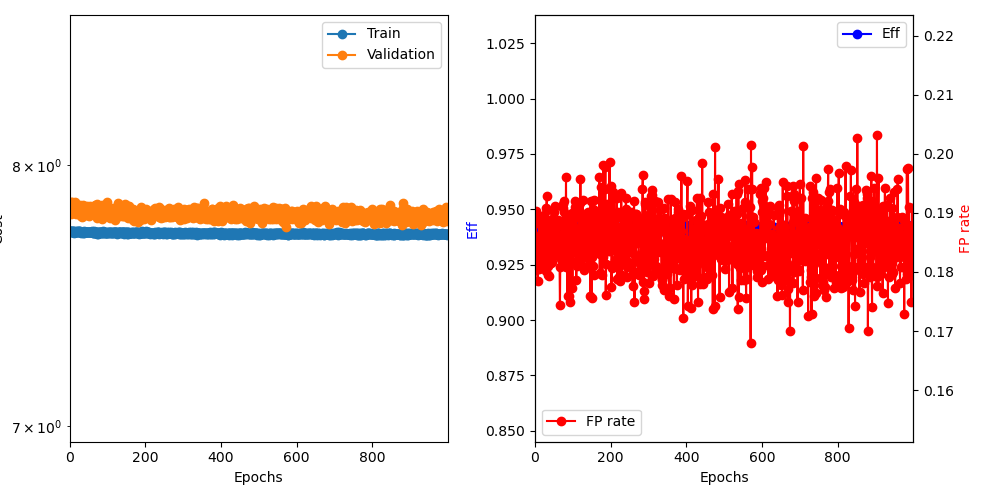

In [11]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

for model:  All_CNN6Layer_A(
  (conv1): Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (finalFilter): Conv1d(1, 1, kernel_size=(91,), stride=(1,), padding=(45,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
)
epoch_start 3317
batch_size 128
epochs 1000
lr 0.0001
Number of batches: train = 1250, val = 78


/home/michael24peters/pv-finder_experimental/notebooks/model/training.py:95: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  file=sys.stderr,


Epoch 3317: train=7.73546, val=7.83229, took 31.543 s
  Validation Found 51268 of 54504, added 1800 (eff 94.06%) (0.18 FP/event)


Epoch 3318: train=7.7355, val=7.81041, took 31.227 s
  Validation Found 51314 of 54504, added 1889 (eff 94.15%) (0.189 FP/event)


Epoch 3319: train=7.73523, val=7.85171, took 31.681 s
  Validation Found 51258 of 54504, added 1816 (eff 94.04%) (0.182 FP/event)


Epoch 3320: train=7.7343, val=7.80164, took 31.317 s
  Validation Found 51317 of 54504, added 1901 (eff 94.15%) (0.19 FP/event)


Epoch 3321: train=7.72919, val=7.82816, took 31.223 s
  Validation Found 51260 of 54504, added 1824 (eff 94.05%) (0.183 FP/event)


Epoch 3322: train=7.73131, val=7.83853, took 31.184 s
  Validation Found 51271 of 54504, added 1819 (eff 94.07%) (0.182 FP/event)


Epoch 3323: train=7.73411, val=7.84219, took 31.472 s
  Validation Found 51260 of 54504, added 1807 (eff 94.05%) (0.181 FP/event)


Epoch 3324: train=7.72923, val=7.8523, took 31.152 s
  Validation Found 51251 of 54504, added 1782 (eff 94.03%) (0.178 FP/event)


Epoch 3325: train=7.73452, val=7.84037, took 31.375 s
  Validation Found 51279 of 54504, added 1803 (eff 94.08%) (0.181 FP/event)


Epoch 3326: train=7.7354, val=7.82152, took 31.133 s
  Validation Found 51302 of 54504, added 1850 (eff 94.13%) (0.185 FP/event)


Epoch 3327: train=7.72879, val=7.8177, took 31.198 s
  Validation Found 51266 of 54504, added 1803 (eff 94.06%) (0.181 FP/event)


Epoch 3328: train=7.7324, val=7.82623, took 31.516 s
  Validation Found 51266 of 54504, added 1820 (eff 94.06%) (0.182 FP/event)


Epoch 3329: train=7.73533, val=7.81623, took 31.316 s
  Validation Found 51294 of 54504, added 1878 (eff 94.11%) (0.188 FP/event)


Epoch 3330: train=7.73151, val=7.82017, took 31.149 s
  Validation Found 51271 of 54504, added 1831 (eff 94.07%) (0.183 FP/event)


Epoch 3331: train=7.7314, val=7.8502, took 31.075 s
  Validation Found 51255 of 54504, added 1809 (eff 94.04%) (0.181 FP/event)


Epoch 3332: train=7.7305, val=7.81426, took 31.294 s
  Validation Found 51286 of 54504, added 1860 (eff 94.10%) (0.186 FP/event)


Epoch 3333: train=7.73409, val=7.83102, took 31.515 s
  Validation Found 51317 of 54504, added 1891 (eff 94.15%) (0.189 FP/event)


Epoch 3334: train=7.73009, val=7.80264, took 31.335 s
  Validation Found 51308 of 54504, added 1862 (eff 94.14%) (0.186 FP/event)


Epoch 3335: train=7.73247, val=7.83927, took 31.407 s
  Validation Found 51270 of 54504, added 1815 (eff 94.07%) (0.182 FP/event)


Epoch 3336: train=7.73495, val=7.81774, took 31.454 s
  Validation Found 51275 of 54504, added 1833 (eff 94.08%) (0.184 FP/event)


Epoch 3337: train=7.72972, val=7.8229, took 31.523 s
  Validation Found 51296 of 54504, added 1854 (eff 94.11%) (0.186 FP/event)


Epoch 3338: train=7.73412, val=7.81117, took 31.679 s
  Validation Found 51295 of 54504, added 1841 (eff 94.11%) (0.184 FP/event)


Epoch 3339: train=7.73268, val=7.80332, took 30.944 s
  Validation Found 51320 of 54504, added 1880 (eff 94.16%) (0.188 FP/event)


Epoch 3340: train=7.73268, val=7.83582, took 31.264 s
  Validation Found 51260 of 54504, added 1807 (eff 94.05%) (0.181 FP/event)


Epoch 3341: train=7.7346, val=7.80866, took 31.031 s
  Validation Found 51335 of 54504, added 1894 (eff 94.19%) (0.19 FP/event)


Epoch 3342: train=7.73337, val=7.83156, took 31.068 s
  Validation Found 51263 of 54504, added 1815 (eff 94.05%) (0.182 FP/event)


Epoch 3343: train=7.73409, val=7.82663, took 31.285 s
  Validation Found 51250 of 54504, added 1804 (eff 94.03%) (0.181 FP/event)


Epoch 3344: train=7.73173, val=7.82615, took 31.335 s
  Validation Found 51314 of 54504, added 1868 (eff 94.15%) (0.187 FP/event)


Epoch 3345: train=7.73068, val=7.83667, took 31.38 s
  Validation Found 51253 of 54504, added 1799 (eff 94.04%) (0.18 FP/event)


Epoch 3346: train=7.72866, val=7.81684, took 31.644 s
  Validation Found 51340 of 54504, added 1905 (eff 94.19%) (0.191 FP/event)


Epoch 3347: train=7.73141, val=7.79367, took 32.172 s
  Validation Found 51295 of 54504, added 1879 (eff 94.11%) (0.188 FP/event)


Epoch 3348: train=7.73214, val=7.81551, took 31.367 s
  Validation Found 51318 of 54504, added 1925 (eff 94.15%) (0.193 FP/event)


Epoch 3349: train=7.73126, val=7.82393, took 31.339 s
  Validation Found 51281 of 54504, added 1829 (eff 94.09%) (0.183 FP/event)


Epoch 3350: train=7.73006, val=7.79249, took 31.418 s
  Validation Found 51318 of 54504, added 1902 (eff 94.15%) (0.19 FP/event)


Epoch 3351: train=7.73007, val=7.83922, took 31.466 s
  Validation Found 51257 of 54504, added 1792 (eff 94.04%) (0.179 FP/event)


Epoch 3352: train=7.73241, val=7.8275, took 31.549 s
  Validation Found 51268 of 54504, added 1807 (eff 94.06%) (0.181 FP/event)


Epoch 3353: train=7.72831, val=7.79578, took 31.394 s
  Validation Found 51327 of 54504, added 1882 (eff 94.17%) (0.188 FP/event)


Epoch 3354: train=7.7349, val=7.80968, took 31.353 s
  Validation Found 51270 of 54504, added 1790 (eff 94.07%) (0.179 FP/event)


Epoch 3355: train=7.72762, val=7.80282, took 31.349 s
  Validation Found 51303 of 54504, added 1857 (eff 94.13%) (0.186 FP/event)


Epoch 3356: train=7.73077, val=7.80689, took 31.172 s
  Validation Found 51304 of 54504, added 1879 (eff 94.13%) (0.188 FP/event)


Epoch 3357: train=7.73128, val=7.82004, took 31.466 s
  Validation Found 51263 of 54504, added 1815 (eff 94.05%) (0.182 FP/event)


Epoch 3358: train=7.73155, val=7.82025, took 31.296 s
  Validation Found 51292 of 54504, added 1827 (eff 94.11%) (0.183 FP/event)


Epoch 3359: train=7.73051, val=7.82244, took 31.459 s
  Validation Found 51291 of 54504, added 1839 (eff 94.11%) (0.184 FP/event)


Epoch 3360: train=7.73104, val=7.81927, took 31.208 s
  Validation Found 51262 of 54504, added 1812 (eff 94.05%) (0.181 FP/event)


Epoch 3361: train=7.72968, val=7.81824, took 31.495 s
  Validation Found 51267 of 54504, added 1832 (eff 94.06%) (0.183 FP/event)


Epoch 3362: train=7.7299, val=7.83563, took 31.405 s
  Validation Found 51260 of 54504, added 1814 (eff 94.05%) (0.182 FP/event)


Epoch 3363: train=7.72916, val=7.80486, took 31.583 s
  Validation Found 51319 of 54504, added 1887 (eff 94.16%) (0.189 FP/event)


Epoch 3364: train=7.73173, val=7.80236, took 31.178 s
  Validation Found 51289 of 54504, added 1846 (eff 94.10%) (0.185 FP/event)


Epoch 3365: train=7.73223, val=7.79757, took 31.393 s
  Validation Found 51308 of 54504, added 1859 (eff 94.14%) (0.186 FP/event)


Epoch 3366: train=7.73173, val=7.8185, took 31.487 s
  Validation Found 51300 of 54504, added 1855 (eff 94.12%) (0.186 FP/event)


Epoch 3367: train=7.72915, val=7.79555, took 31.108 s
  Validation Found 51322 of 54504, added 1898 (eff 94.16%) (0.19 FP/event)


Epoch 3368: train=7.73097, val=7.832, took 31.237 s
  Validation Found 51294 of 54504, added 1871 (eff 94.11%) (0.187 FP/event)


Epoch 3369: train=7.72948, val=7.79973, took 31.33 s
  Validation Found 51339 of 54504, added 1909 (eff 94.19%) (0.191 FP/event)


Epoch 3370: train=7.73064, val=7.83031, took 31.181 s
  Validation Found 51263 of 54504, added 1826 (eff 94.05%) (0.183 FP/event)


Epoch 3371: train=7.72942, val=7.83259, took 31.293 s
  Validation Found 51265 of 54504, added 1827 (eff 94.06%) (0.183 FP/event)


Epoch 3372: train=7.73254, val=7.80618, took 31.397 s
  Validation Found 51290 of 54504, added 1841 (eff 94.10%) (0.184 FP/event)


Epoch 3373: train=7.73139, val=7.80552, took 31.205 s
  Validation Found 51325 of 54504, added 1874 (eff 94.17%) (0.188 FP/event)


Epoch 3374: train=7.7297, val=7.81201, took 31.324 s
  Validation Found 51283 of 54504, added 1827 (eff 94.09%) (0.183 FP/event)


Epoch 3375: train=7.73198, val=7.80723, took 31.413 s
  Validation Found 51308 of 54504, added 1878 (eff 94.14%) (0.188 FP/event)


Epoch 3376: train=7.73496, val=7.81725, took 31.465 s
  Validation Found 51318 of 54504, added 1872 (eff 94.15%) (0.187 FP/event)


Epoch 3377: train=7.72921, val=7.82649, took 31.334 s
  Validation Found 51279 of 54504, added 1826 (eff 94.08%) (0.183 FP/event)


Epoch 3378: train=7.72596, val=7.82277, took 31.286 s
  Validation Found 51299 of 54504, added 1848 (eff 94.12%) (0.185 FP/event)


Epoch 3379: train=7.72885, val=7.80485, took 31.708 s
  Validation Found 51331 of 54504, added 1886 (eff 94.18%) (0.189 FP/event)


Epoch 3380: train=7.73029, val=7.80646, took 31.247 s
  Validation Found 51270 of 54504, added 1824 (eff 94.07%) (0.183 FP/event)


Epoch 3381: train=7.73421, val=7.81929, took 31.325 s
  Validation Found 51276 of 54504, added 1827 (eff 94.08%) (0.183 FP/event)


Epoch 3382: train=7.72825, val=7.82933, took 31.31 s
  Validation Found 51286 of 54504, added 1806 (eff 94.10%) (0.181 FP/event)


Epoch 3383: train=7.73031, val=7.83919, took 31.756 s
  Validation Found 51218 of 54504, added 1741 (eff 93.97%) (0.174 FP/event)


Epoch 3384: train=7.72717, val=7.82811, took 31.332 s
  Validation Found 51273 of 54504, added 1825 (eff 94.07%) (0.183 FP/event)


Epoch 3385: train=7.72928, val=7.8209, took 31.501 s
  Validation Found 51291 of 54504, added 1820 (eff 94.11%) (0.182 FP/event)


Epoch 3386: train=7.72769, val=7.82838, took 31.514 s
  Validation Found 51270 of 54504, added 1833 (eff 94.07%) (0.184 FP/event)


Epoch 3387: train=7.7312, val=7.8113, took 31.279 s
  Validation Found 51295 of 54504, added 1860 (eff 94.11%) (0.186 FP/event)


Epoch 3388: train=7.72927, val=7.81536, took 31.353 s
  Validation Found 51282 of 54504, added 1839 (eff 94.09%) (0.184 FP/event)


Epoch 3389: train=7.73111, val=7.78601, took 31.518 s
  Validation Found 51322 of 54504, added 1883 (eff 94.16%) (0.189 FP/event)


Epoch 3390: train=7.72506, val=7.84277, took 31.125 s
  Validation Found 51256 of 54504, added 1814 (eff 94.04%) (0.182 FP/event)


Epoch 3391: train=7.72501, val=7.79611, took 31.376 s
  Validation Found 51349 of 54504, added 1906 (eff 94.21%) (0.191 FP/event)


Epoch 3392: train=7.7285, val=7.79711, took 31.243 s
  Validation Found 51354 of 54504, added 1912 (eff 94.22%) (0.191 FP/event)


Epoch 3393: train=7.73165, val=7.83074, took 31.234 s
  Validation Found 51277 of 54504, added 1820 (eff 94.08%) (0.182 FP/event)


Epoch 3394: train=7.73099, val=7.80077, took 31.301 s
  Validation Found 51327 of 54504, added 1899 (eff 94.17%) (0.19 FP/event)


Epoch 3395: train=7.73235, val=7.8151, took 31.38 s
  Validation Found 51350 of 54504, added 1918 (eff 94.21%) (0.192 FP/event)


Epoch 3396: train=7.72967, val=7.80937, took 31.515 s
  Validation Found 51323 of 54504, added 1838 (eff 94.16%) (0.184 FP/event)


Epoch 3397: train=7.72955, val=7.8109, took 31.346 s
  Validation Found 51306 of 54504, added 1866 (eff 94.13%) (0.187 FP/event)


Epoch 3398: train=7.72578, val=7.80296, took 31.274 s
  Validation Found 51289 of 54504, added 1857 (eff 94.10%) (0.186 FP/event)


Epoch 3399: train=7.73164, val=7.79067, took 31.388 s
  Validation Found 51360 of 54504, added 1958 (eff 94.23%) (0.196 FP/event)


Epoch 3400: train=7.72859, val=7.82243, took 31.237 s
  Validation Found 51274 of 54504, added 1805 (eff 94.07%) (0.181 FP/event)


Epoch 3401: train=7.72995, val=7.78395, took 31.94 s
  Validation Found 51345 of 54504, added 1887 (eff 94.20%) (0.189 FP/event)


Epoch 3402: train=7.73057, val=7.82035, took 31.798 s
  Validation Found 51273 of 54504, added 1819 (eff 94.07%) (0.182 FP/event)


Epoch 3403: train=7.72834, val=7.83909, took 31.448 s
  Validation Found 51242 of 54504, added 1756 (eff 94.02%) (0.176 FP/event)


Epoch 3404: train=7.72737, val=7.79188, took 31.305 s
  Validation Found 51315 of 54504, added 1875 (eff 94.15%) (0.188 FP/event)


Epoch 3405: train=7.72895, val=7.83027, took 31.289 s
  Validation Found 51266 of 54504, added 1816 (eff 94.06%) (0.182 FP/event)


Epoch 3406: train=7.73327, val=7.80217, took 31.181 s
  Validation Found 51342 of 54504, added 1882 (eff 94.20%) (0.188 FP/event)


Epoch 3407: train=7.73142, val=7.80722, took 31.332 s
  Validation Found 51303 of 54504, added 1843 (eff 94.13%) (0.185 FP/event)


Epoch 3408: train=7.73097, val=7.83257, took 31.151 s
  Validation Found 51243 of 54504, added 1757 (eff 94.02%) (0.176 FP/event)


Epoch 3409: train=7.7287, val=7.80546, took 31.413 s
  Validation Found 51345 of 54504, added 1894 (eff 94.20%) (0.19 FP/event)


Epoch 3410: train=7.72789, val=7.82066, took 31.374 s
  Validation Found 51257 of 54504, added 1747 (eff 94.04%) (0.175 FP/event)


Epoch 3411: train=7.7298, val=7.80278, took 31.245 s
  Validation Found 51313 of 54504, added 1864 (eff 94.15%) (0.187 FP/event)


Epoch 3412: train=7.72871, val=7.81581, took 31.527 s
  Validation Found 51277 of 54504, added 1831 (eff 94.08%) (0.183 FP/event)


Epoch 3413: train=7.73167, val=7.81737, took 31.378 s
  Validation Found 51292 of 54504, added 1846 (eff 94.11%) (0.185 FP/event)


Epoch 3414: train=7.72602, val=7.79976, took 31.102 s
  Validation Found 51339 of 54504, added 1897 (eff 94.19%) (0.19 FP/event)


Epoch 3415: train=7.72706, val=7.82307, took 31.382 s
  Validation Found 51286 of 54504, added 1816 (eff 94.10%) (0.182 FP/event)


Epoch 3416: train=7.72771, val=7.84986, took 31.39 s
  Validation Found 51239 of 54504, added 1770 (eff 94.01%) (0.177 FP/event)


Epoch 3417: train=7.72525, val=7.80189, took 31.379 s
  Validation Found 51305 of 54504, added 1831 (eff 94.13%) (0.183 FP/event)


Epoch 3418: train=7.73147, val=7.81773, took 31.426 s
  Validation Found 51293 of 54504, added 1814 (eff 94.11%) (0.182 FP/event)


Epoch 3419: train=7.7308, val=7.80979, took 31.608 s
  Validation Found 51310 of 54504, added 1859 (eff 94.14%) (0.186 FP/event)


Epoch 3420: train=7.73015, val=7.80247, took 31.204 s
  Validation Found 51326 of 54504, added 1889 (eff 94.17%) (0.189 FP/event)


Epoch 3421: train=7.72595, val=7.81093, took 31.221 s
  Validation Found 51305 of 54504, added 1855 (eff 94.13%) (0.186 FP/event)


Epoch 3422: train=7.72784, val=7.79596, took 32.094 s
  Validation Found 51344 of 54504, added 1907 (eff 94.20%) (0.191 FP/event)


Epoch 3423: train=7.73138, val=7.81099, took 31.415 s
  Validation Found 51316 of 54504, added 1873 (eff 94.15%) (0.188 FP/event)


Epoch 3424: train=7.72936, val=7.78673, took 31.53 s
  Validation Found 51368 of 54504, added 1917 (eff 94.25%) (0.192 FP/event)


Epoch 3425: train=7.73049, val=7.79293, took 31.98 s
  Validation Found 51329 of 54504, added 1900 (eff 94.17%) (0.19 FP/event)


Epoch 3426: train=7.72624, val=7.8264, took 31.44 s
  Validation Found 51259 of 54504, added 1784 (eff 94.05%) (0.179 FP/event)


Epoch 3427: train=7.73063, val=7.81017, took 31.121 s
  Validation Found 51278 of 54504, added 1808 (eff 94.08%) (0.181 FP/event)


Epoch 3428: train=7.72683, val=7.8182, took 31.332 s
  Validation Found 51288 of 54504, added 1865 (eff 94.10%) (0.187 FP/event)


Epoch 3429: train=7.72769, val=7.81968, took 31.452 s
  Validation Found 51286 of 54504, added 1838 (eff 94.10%) (0.184 FP/event)


Epoch 3430: train=7.72952, val=7.82147, took 31.272 s
  Validation Found 51282 of 54504, added 1817 (eff 94.09%) (0.182 FP/event)


Epoch 3431: train=7.72905, val=7.8156, took 31.291 s
  Validation Found 51290 of 54504, added 1838 (eff 94.10%) (0.184 FP/event)


Epoch 3432: train=7.72959, val=7.80202, took 31.321 s
  Validation Found 51319 of 54504, added 1863 (eff 94.16%) (0.187 FP/event)


Epoch 3433: train=7.72965, val=7.81485, took 31.443 s
  Validation Found 51281 of 54504, added 1812 (eff 94.09%) (0.181 FP/event)


Epoch 3434: train=7.72993, val=7.80475, took 31.395 s
  Validation Found 51275 of 54504, added 1830 (eff 94.08%) (0.183 FP/event)


Epoch 3435: train=7.72709, val=7.80686, took 31.387 s
  Validation Found 51349 of 54504, added 1914 (eff 94.21%) (0.192 FP/event)


Epoch 3436: train=7.72997, val=7.7967, took 31.357 s
  Validation Found 51329 of 54504, added 1898 (eff 94.17%) (0.19 FP/event)


Epoch 3437: train=7.72914, val=7.77927, took 31.294 s
  Validation Found 51377 of 54504, added 1955 (eff 94.26%) (0.196 FP/event)


Epoch 3438: train=7.73009, val=7.80763, took 31.25 s
  Validation Found 51333 of 54504, added 1886 (eff 94.18%) (0.189 FP/event)


Epoch 3439: train=7.73094, val=7.81956, took 31.312 s
  Validation Found 51314 of 54504, added 1893 (eff 94.15%) (0.19 FP/event)


Epoch 3440: train=7.73013, val=7.83121, took 31.28 s
  Validation Found 51283 of 54504, added 1824 (eff 94.09%) (0.183 FP/event)


Epoch 3441: train=7.72413, val=7.80134, took 31.493 s
  Validation Found 51285 of 54504, added 1853 (eff 94.09%) (0.186 FP/event)


Epoch 3442: train=7.72644, val=7.8144, took 31.224 s
  Validation Found 51306 of 54504, added 1858 (eff 94.13%) (0.186 FP/event)


Epoch 3443: train=7.72666, val=7.79432, took 31.299 s
  Validation Found 51340 of 54504, added 1919 (eff 94.19%) (0.192 FP/event)


Epoch 3444: train=7.72969, val=7.84603, took 31.331 s
  Validation Found 51260 of 54504, added 1824 (eff 94.05%) (0.183 FP/event)


Epoch 3445: train=7.72773, val=7.81717, took 31.178 s
  Validation Found 51304 of 54504, added 1836 (eff 94.13%) (0.184 FP/event)


Epoch 3446: train=7.7314, val=7.81378, took 31.424 s
  Validation Found 51292 of 54504, added 1845 (eff 94.11%) (0.185 FP/event)


Epoch 3447: train=7.72986, val=7.8123, took 31.541 s
  Validation Found 51270 of 54504, added 1801 (eff 94.07%) (0.18 FP/event)


Epoch 3448: train=7.73252, val=7.80317, took 31.227 s
  Validation Found 51294 of 54504, added 1843 (eff 94.11%) (0.185 FP/event)


Epoch 3449: train=7.72536, val=7.80081, took 31.303 s
  Validation Found 51330 of 54504, added 1894 (eff 94.18%) (0.19 FP/event)


Epoch 3450: train=7.73289, val=7.79357, took 31.438 s
  Validation Found 51324 of 54504, added 1867 (eff 94.17%) (0.187 FP/event)


Epoch 3451: train=7.73123, val=7.80721, took 31.359 s
  Validation Found 51321 of 54504, added 1875 (eff 94.16%) (0.188 FP/event)


Epoch 3452: train=7.7276, val=7.80246, took 31.376 s
  Validation Found 51294 of 54504, added 1848 (eff 94.11%) (0.185 FP/event)


Epoch 3453: train=7.73116, val=7.79901, took 31.178 s
  Validation Found 51326 of 54504, added 1894 (eff 94.17%) (0.19 FP/event)


Epoch 3454: train=7.73106, val=7.81416, took 31.25 s
  Validation Found 51305 of 54504, added 1821 (eff 94.13%) (0.182 FP/event)


Epoch 3455: train=7.72828, val=7.80725, took 31.426 s
  Validation Found 51333 of 54504, added 1871 (eff 94.18%) (0.187 FP/event)


Epoch 3456: train=7.73033, val=7.81675, took 31.33 s
  Validation Found 51255 of 54504, added 1808 (eff 94.04%) (0.181 FP/event)


Epoch 3457: train=7.72958, val=7.79565, took 31.236 s
  Validation Found 51339 of 54504, added 1898 (eff 94.19%) (0.19 FP/event)


Epoch 3458: train=7.72957, val=7.79474, took 31.361 s
  Validation Found 51327 of 54504, added 1874 (eff 94.17%) (0.188 FP/event)


Epoch 3459: train=7.73107, val=7.80383, took 31.296 s
  Validation Found 51330 of 54504, added 1889 (eff 94.18%) (0.189 FP/event)


Epoch 3460: train=7.72483, val=7.79779, took 31.273 s
  Validation Found 51313 of 54504, added 1854 (eff 94.15%) (0.186 FP/event)


Epoch 3461: train=7.73076, val=7.79683, took 31.667 s
  Validation Found 51328 of 54504, added 1885 (eff 94.17%) (0.189 FP/event)


Epoch 3462: train=7.73004, val=7.80576, took 31.525 s
  Validation Found 51318 of 54504, added 1870 (eff 94.15%) (0.187 FP/event)


Epoch 3463: train=7.72694, val=7.84372, took 31.596 s
  Validation Found 51234 of 54504, added 1757 (eff 94.00%) (0.176 FP/event)


Epoch 3464: train=7.73153, val=7.79358, took 31.522 s
  Validation Found 51344 of 54504, added 1917 (eff 94.20%) (0.192 FP/event)


Epoch 3465: train=7.72567, val=7.80759, took 31.371 s
  Validation Found 51295 of 54504, added 1837 (eff 94.11%) (0.184 FP/event)


Epoch 3466: train=7.72937, val=7.81015, took 31.369 s
  Validation Found 51291 of 54504, added 1807 (eff 94.11%) (0.181 FP/event)


Epoch 3467: train=7.72982, val=7.8264, took 31.357 s
  Validation Found 51254 of 54504, added 1753 (eff 94.04%) (0.176 FP/event)


Epoch 3468: train=7.72497, val=7.8123, took 31.267 s
  Validation Found 51278 of 54504, added 1822 (eff 94.08%) (0.182 FP/event)


Epoch 3469: train=7.72918, val=7.79286, took 31.599 s
  Validation Found 51326 of 54504, added 1894 (eff 94.17%) (0.19 FP/event)


Epoch 3470: train=7.73149, val=7.78709, took 31.335 s
  Validation Found 51338 of 54504, added 1903 (eff 94.19%) (0.191 FP/event)


Epoch 3471: train=7.72692, val=7.83548, took 31.146 s
  Validation Found 51260 of 54504, added 1807 (eff 94.05%) (0.181 FP/event)


Epoch 3472: train=7.72463, val=7.79095, took 31.328 s
  Validation Found 51355 of 54504, added 1919 (eff 94.22%) (0.192 FP/event)


Epoch 3473: train=7.72762, val=7.83372, took 31.395 s
  Validation Found 51281 of 54504, added 1793 (eff 94.09%) (0.18 FP/event)


Epoch 3474: train=7.7299, val=7.79523, took 31.292 s
  Validation Found 51315 of 54504, added 1878 (eff 94.15%) (0.188 FP/event)


Epoch 3475: train=7.72658, val=7.81948, took 31.407 s
  Validation Found 51308 of 54504, added 1865 (eff 94.14%) (0.187 FP/event)


Epoch 3476: train=7.72619, val=7.79787, took 31.335 s
  Validation Found 51345 of 54504, added 1886 (eff 94.20%) (0.189 FP/event)


Epoch 3477: train=7.7286, val=7.79493, took 31.48 s
  Validation Found 51301 of 54504, added 1832 (eff 94.12%) (0.183 FP/event)


Epoch 3478: train=7.72645, val=7.81312, took 31.156 s
  Validation Found 51335 of 54504, added 1871 (eff 94.19%) (0.187 FP/event)


Epoch 3479: train=7.72868, val=7.8018, took 31.295 s
  Validation Found 51330 of 54504, added 1860 (eff 94.18%) (0.186 FP/event)


Epoch 3480: train=7.7258, val=7.81444, took 31.239 s
  Validation Found 51306 of 54504, added 1842 (eff 94.13%) (0.184 FP/event)


Epoch 3481: train=7.72926, val=7.80239, took 31.394 s
  Validation Found 51330 of 54504, added 1870 (eff 94.18%) (0.187 FP/event)


Epoch 3482: train=7.73011, val=7.8061, took 31.557 s
  Validation Found 51332 of 54504, added 1882 (eff 94.18%) (0.188 FP/event)


Epoch 3483: train=7.72751, val=7.77866, took 31.244 s
  Validation Found 51313 of 54504, added 1860 (eff 94.15%) (0.186 FP/event)


Epoch 3484: train=7.7287, val=7.82073, took 31.5 s
  Validation Found 51316 of 54504, added 1900 (eff 94.15%) (0.19 FP/event)


Epoch 3485: train=7.7255, val=7.80781, took 31.535 s
  Validation Found 51340 of 54504, added 1901 (eff 94.19%) (0.19 FP/event)


Epoch 3486: train=7.72604, val=7.78967, took 30.872 s
  Validation Found 51328 of 54504, added 1890 (eff 94.17%) (0.189 FP/event)


Epoch 3487: train=7.72776, val=7.77502, took 30.839 s
  Validation Found 51378 of 54504, added 1958 (eff 94.26%) (0.196 FP/event)


Epoch 3488: train=7.72931, val=7.80426, took 30.815 s
  Validation Found 51265 of 54504, added 1796 (eff 94.06%) (0.18 FP/event)


Epoch 3489: train=7.72673, val=7.80265, took 30.836 s
  Validation Found 51272 of 54504, added 1828 (eff 94.07%) (0.183 FP/event)


Epoch 3490: train=7.73003, val=7.80505, took 30.828 s
  Validation Found 51305 of 54504, added 1851 (eff 94.13%) (0.185 FP/event)


Epoch 3491: train=7.72718, val=7.81434, took 31.127 s
  Validation Found 51266 of 54504, added 1794 (eff 94.06%) (0.18 FP/event)


Epoch 3492: train=7.72944, val=7.78917, took 31.206 s
  Validation Found 51365 of 54504, added 1941 (eff 94.24%) (0.194 FP/event)


Epoch 3493: train=7.73017, val=7.79475, took 31.425 s
  Validation Found 51325 of 54504, added 1875 (eff 94.17%) (0.188 FP/event)


Epoch 3494: train=7.73017, val=7.79892, took 31.409 s
  Validation Found 51310 of 54504, added 1883 (eff 94.14%) (0.189 FP/event)


Epoch 3495: train=7.7295, val=7.79792, took 31.371 s
  Validation Found 51269 of 54504, added 1793 (eff 94.06%) (0.18 FP/event)


Epoch 3496: train=7.729, val=7.80874, took 31.247 s
  Validation Found 51308 of 54504, added 1864 (eff 94.14%) (0.187 FP/event)


Epoch 3497: train=7.7325, val=7.80854, took 31.383 s
  Validation Found 51285 of 54504, added 1823 (eff 94.09%) (0.183 FP/event)


Epoch 3498: train=7.72532, val=7.77045, took 31.565 s
  Validation Found 51388 of 54504, added 1979 (eff 94.28%) (0.198 FP/event)


Epoch 3499: train=7.72355, val=7.79926, took 31.346 s
  Validation Found 51302 of 54504, added 1855 (eff 94.13%) (0.186 FP/event)


Epoch 3500: train=7.72806, val=7.79582, took 31.36 s
  Validation Found 51310 of 54504, added 1858 (eff 94.14%) (0.186 FP/event)


Epoch 3501: train=7.73136, val=7.79808, took 31.384 s
  Validation Found 51367 of 54504, added 1938 (eff 94.24%) (0.194 FP/event)


Epoch 3502: train=7.72685, val=7.79828, took 31.497 s
  Validation Found 51334 of 54504, added 1880 (eff 94.18%) (0.188 FP/event)


Epoch 3503: train=7.72797, val=7.77988, took 31.324 s
  Validation Found 51372 of 54504, added 1975 (eff 94.25%) (0.198 FP/event)


Epoch 3504: train=7.73048, val=7.83028, took 31.661 s
  Validation Found 51261 of 54504, added 1758 (eff 94.05%) (0.176 FP/event)


Epoch 3505: train=7.72882, val=7.82228, took 31.313 s
  Validation Found 51261 of 54504, added 1810 (eff 94.05%) (0.181 FP/event)


Epoch 3506: train=7.72622, val=7.80739, took 31.357 s
  Validation Found 51290 of 54504, added 1842 (eff 94.10%) (0.184 FP/event)


Epoch 3507: train=7.72889, val=7.78176, took 31.69 s
  Validation Found 51354 of 54504, added 1912 (eff 94.22%) (0.191 FP/event)


Epoch 3508: train=7.72699, val=7.80696, took 31.579 s
  Validation Found 51324 of 54504, added 1858 (eff 94.17%) (0.186 FP/event)


Epoch 3509: train=7.73411, val=7.80753, took 31.279 s
  Validation Found 51307 of 54504, added 1849 (eff 94.13%) (0.185 FP/event)


Epoch 3510: train=7.72849, val=7.7866, took 31.254 s
  Validation Found 51293 of 54504, added 1833 (eff 94.11%) (0.184 FP/event)


Epoch 3511: train=7.72871, val=7.79236, took 31.4 s
  Validation Found 51335 of 54504, added 1893 (eff 94.19%) (0.19 FP/event)


Epoch 3512: train=7.73132, val=7.81023, took 31.338 s
  Validation Found 51305 of 54504, added 1859 (eff 94.13%) (0.186 FP/event)


Epoch 3513: train=7.72697, val=7.78818, took 31.307 s
  Validation Found 51324 of 54504, added 1867 (eff 94.17%) (0.187 FP/event)


Epoch 3514: train=7.72797, val=7.78099, took 31.318 s
  Validation Found 51383 of 54504, added 1984 (eff 94.27%) (0.199 FP/event)


Epoch 3515: train=7.72914, val=7.80779, took 31.232 s
  Validation Found 51309 of 54504, added 1833 (eff 94.14%) (0.184 FP/event)


Epoch 3516: train=7.72704, val=7.81492, took 31.321 s
  Validation Found 51320 of 54504, added 1878 (eff 94.16%) (0.188 FP/event)


Epoch 3517: train=7.72674, val=7.79705, took 31.266 s
  Validation Found 51307 of 54504, added 1864 (eff 94.13%) (0.187 FP/event)


Epoch 3518: train=7.7339, val=7.79108, took 31.209 s
  Validation Found 51357 of 54504, added 1942 (eff 94.23%) (0.194 FP/event)


Epoch 3519: train=7.73117, val=7.82299, took 31.213 s
  Validation Found 51253 of 54504, added 1772 (eff 94.04%) (0.177 FP/event)


Epoch 3520: train=7.72829, val=7.7999, took 31.311 s
  Validation Found 51303 of 54504, added 1804 (eff 94.13%) (0.181 FP/event)


Epoch 3521: train=7.72943, val=7.81087, took 31.338 s
  Validation Found 51280 of 54504, added 1809 (eff 94.08%) (0.181 FP/event)


Epoch 3522: train=7.72839, val=7.80494, took 31.444 s
  Validation Found 51293 of 54504, added 1856 (eff 94.11%) (0.186 FP/event)


Epoch 3523: train=7.72888, val=7.79463, took 31.32 s
  Validation Found 51362 of 54504, added 1932 (eff 94.24%) (0.193 FP/event)


Epoch 3524: train=7.72981, val=7.80574, took 31.229 s
  Validation Found 51321 of 54504, added 1894 (eff 94.16%) (0.19 FP/event)


Epoch 3525: train=7.7304, val=7.79839, took 31.628 s
  Validation Found 51309 of 54504, added 1848 (eff 94.14%) (0.185 FP/event)


Epoch 3526: train=7.72538, val=7.78887, took 31.362 s
  Validation Found 51369 of 54504, added 1922 (eff 94.25%) (0.192 FP/event)


Epoch 3527: train=7.72913, val=7.80016, took 31.386 s
  Validation Found 51307 of 54504, added 1880 (eff 94.13%) (0.188 FP/event)


Epoch 3528: train=7.727, val=7.79923, took 31.501 s
  Validation Found 51268 of 54504, added 1817 (eff 94.06%) (0.182 FP/event)


Epoch 3529: train=7.72667, val=7.81393, took 31.74 s
  Validation Found 51304 of 54504, added 1850 (eff 94.13%) (0.185 FP/event)


Epoch 3530: train=7.72454, val=7.81127, took 31.638 s
  Validation Found 51300 of 54504, added 1837 (eff 94.12%) (0.184 FP/event)


Epoch 3531: train=7.7275, val=7.79942, took 31.236 s
  Validation Found 51319 of 54504, added 1865 (eff 94.16%) (0.187 FP/event)


Epoch 3532: train=7.7252, val=7.80923, took 31.388 s
  Validation Found 51308 of 54504, added 1838 (eff 94.14%) (0.184 FP/event)


Epoch 3533: train=7.72674, val=7.77966, took 31.239 s
  Validation Found 51351 of 54504, added 1923 (eff 94.22%) (0.193 FP/event)


Epoch 3534: train=7.72837, val=7.81311, took 31.494 s
  Validation Found 51268 of 54504, added 1813 (eff 94.06%) (0.182 FP/event)


Epoch 3535: train=7.72697, val=7.81433, took 31.475 s
  Validation Found 51271 of 54504, added 1785 (eff 94.07%) (0.179 FP/event)


Epoch 3536: train=7.72517, val=7.79653, took 31.441 s
  Validation Found 51342 of 54504, added 1899 (eff 94.20%) (0.19 FP/event)


Epoch 3537: train=7.72459, val=7.79488, took 31.272 s
  Validation Found 51346 of 54504, added 1897 (eff 94.21%) (0.19 FP/event)


Epoch 3538: train=7.72815, val=7.80082, took 31.3 s
  Validation Found 51295 of 54504, added 1873 (eff 94.11%) (0.188 FP/event)


Epoch 3539: train=7.72717, val=7.81466, took 31.312 s
  Validation Found 51274 of 54504, added 1789 (eff 94.07%) (0.179 FP/event)


Epoch 3540: train=7.72249, val=7.82133, took 31.343 s
  Validation Found 51246 of 54504, added 1788 (eff 94.02%) (0.179 FP/event)


Epoch 3541: train=7.72602, val=7.80404, took 31.484 s
  Validation Found 51313 of 54504, added 1867 (eff 94.15%) (0.187 FP/event)


Epoch 3542: train=7.72934, val=7.81023, took 31.864 s
  Validation Found 51281 of 54504, added 1838 (eff 94.09%) (0.184 FP/event)


Epoch 3543: train=7.72497, val=7.82661, took 31.421 s
  Validation Found 51259 of 54504, added 1782 (eff 94.05%) (0.178 FP/event)


Epoch 3544: train=7.72768, val=7.82307, took 31.373 s
  Validation Found 51283 of 54504, added 1820 (eff 94.09%) (0.182 FP/event)


Epoch 3545: train=7.72673, val=7.79837, took 31.554 s
  Validation Found 51355 of 54504, added 1931 (eff 94.22%) (0.193 FP/event)


Epoch 3546: train=7.72892, val=7.8088, took 31.18 s
  Validation Found 51303 of 54504, added 1831 (eff 94.13%) (0.183 FP/event)


Epoch 3547: train=7.73111, val=7.82037, took 31.145 s
  Validation Found 51272 of 54504, added 1793 (eff 94.07%) (0.18 FP/event)


Epoch 3548: train=7.7254, val=7.80063, took 31.307 s
  Validation Found 51321 of 54504, added 1889 (eff 94.16%) (0.189 FP/event)


Epoch 3549: train=7.72959, val=7.80083, took 31.315 s
  Validation Found 51300 of 54504, added 1834 (eff 94.12%) (0.184 FP/event)


Epoch 3550: train=7.72852, val=7.81689, took 31.435 s
  Validation Found 51303 of 54504, added 1822 (eff 94.13%) (0.182 FP/event)


Epoch 3551: train=7.73107, val=7.8013, took 31.619 s
  Validation Found 51338 of 54504, added 1892 (eff 94.19%) (0.189 FP/event)


Epoch 3552: train=7.725, val=7.78965, took 31.422 s
  Validation Found 51330 of 54504, added 1863 (eff 94.18%) (0.187 FP/event)


Epoch 3553: train=7.72676, val=7.79934, took 31.273 s
  Validation Found 51287 of 54504, added 1822 (eff 94.10%) (0.182 FP/event)


Epoch 3554: train=7.73283, val=7.82978, took 31.197 s
  Validation Found 51273 of 54504, added 1811 (eff 94.07%) (0.181 FP/event)


Epoch 3555: train=7.72698, val=7.8153, took 31.314 s
  Validation Found 51310 of 54504, added 1847 (eff 94.14%) (0.185 FP/event)


Epoch 3556: train=7.72772, val=7.81764, took 31.331 s
  Validation Found 51276 of 54504, added 1819 (eff 94.08%) (0.182 FP/event)


Epoch 3557: train=7.72771, val=7.78608, took 31.292 s
  Validation Found 51350 of 54504, added 1922 (eff 94.21%) (0.192 FP/event)


Epoch 3558: train=7.72538, val=7.79399, took 31.528 s
  Validation Found 51359 of 54504, added 1904 (eff 94.23%) (0.191 FP/event)


Epoch 3559: train=7.72675, val=7.82311, took 31.235 s
  Validation Found 51262 of 54504, added 1788 (eff 94.05%) (0.179 FP/event)


Epoch 3560: train=7.72964, val=7.78995, took 31.371 s
  Validation Found 51318 of 54504, added 1891 (eff 94.15%) (0.189 FP/event)


Epoch 3561: train=7.72593, val=7.80849, took 31.342 s
  Validation Found 51281 of 54504, added 1805 (eff 94.09%) (0.181 FP/event)


Epoch 3562: train=7.72868, val=7.79905, took 31.157 s
  Validation Found 51315 of 54504, added 1857 (eff 94.15%) (0.186 FP/event)


Epoch 3563: train=7.72404, val=7.78936, took 31.766 s
  Validation Found 51301 of 54504, added 1815 (eff 94.12%) (0.182 FP/event)


Epoch 3564: train=7.72861, val=7.80275, took 31.233 s
  Validation Found 51327 of 54504, added 1897 (eff 94.17%) (0.19 FP/event)


Epoch 3565: train=7.72925, val=7.8062, took 31.341 s
  Validation Found 51316 of 54504, added 1875 (eff 94.15%) (0.188 FP/event)


Epoch 3566: train=7.72803, val=7.80774, took 31.355 s
  Validation Found 51275 of 54504, added 1813 (eff 94.08%) (0.182 FP/event)


Epoch 3567: train=7.73023, val=7.8116, took 31.343 s
  Validation Found 51313 of 54504, added 1852 (eff 94.15%) (0.185 FP/event)


Epoch 3568: train=7.72569, val=7.79377, took 31.75 s
  Validation Found 51302 of 54504, added 1874 (eff 94.13%) (0.188 FP/event)


Epoch 3569: train=7.73071, val=7.81584, took 31.064 s
  Validation Found 51296 of 54504, added 1843 (eff 94.11%) (0.185 FP/event)


Epoch 3570: train=7.72667, val=7.79247, took 31.116 s
  Validation Found 51357 of 54504, added 1899 (eff 94.23%) (0.19 FP/event)


Epoch 3571: train=7.7289, val=7.79534, took 31.181 s
  Validation Found 51303 of 54504, added 1867 (eff 94.13%) (0.187 FP/event)


Epoch 3572: train=7.72295, val=7.80542, took 31.18 s
  Validation Found 51310 of 54504, added 1831 (eff 94.14%) (0.183 FP/event)


Epoch 3573: train=7.73032, val=7.79388, took 31.3 s
  Validation Found 51317 of 54504, added 1868 (eff 94.15%) (0.187 FP/event)


Epoch 3574: train=7.72324, val=7.80283, took 31.254 s
  Validation Found 51293 of 54504, added 1833 (eff 94.11%) (0.184 FP/event)


Epoch 3575: train=7.72847, val=7.81356, took 31.811 s
  Validation Found 51265 of 54504, added 1773 (eff 94.06%) (0.178 FP/event)


Epoch 3576: train=7.72708, val=7.81043, took 31.778 s
  Validation Found 51289 of 54504, added 1796 (eff 94.10%) (0.18 FP/event)


Epoch 3577: train=7.7288, val=7.82106, took 31.413 s
  Validation Found 51292 of 54504, added 1830 (eff 94.11%) (0.183 FP/event)


Epoch 3578: train=7.72805, val=7.79762, took 31.336 s
  Validation Found 51338 of 54504, added 1893 (eff 94.19%) (0.19 FP/event)


Epoch 3579: train=7.7302, val=7.79113, took 31.339 s
  Validation Found 51340 of 54504, added 1918 (eff 94.19%) (0.192 FP/event)


Epoch 3580: train=7.72592, val=7.8265, took 31.401 s
  Validation Found 51243 of 54504, added 1746 (eff 94.02%) (0.175 FP/event)


Epoch 3581: train=7.72586, val=7.80671, took 31.666 s
  Validation Found 51346 of 54504, added 1887 (eff 94.21%) (0.189 FP/event)


Epoch 3582: train=7.72815, val=7.79095, took 31.293 s
  Validation Found 51332 of 54504, added 1877 (eff 94.18%) (0.188 FP/event)


Epoch 3583: train=7.72659, val=7.80527, took 31.26 s
  Validation Found 51330 of 54504, added 1895 (eff 94.18%) (0.19 FP/event)


Epoch 3584: train=7.72523, val=7.81227, took 31.251 s
  Validation Found 51281 of 54504, added 1819 (eff 94.09%) (0.182 FP/event)


Epoch 3585: train=7.73034, val=7.79958, took 31.487 s
  Validation Found 51348 of 54504, added 1895 (eff 94.21%) (0.19 FP/event)


Epoch 3586: train=7.72498, val=7.80464, took 31.407 s
  Validation Found 51333 of 54504, added 1892 (eff 94.18%) (0.189 FP/event)


Epoch 3587: train=7.72513, val=7.7912, took 31.243 s
  Validation Found 51307 of 54504, added 1846 (eff 94.13%) (0.185 FP/event)


Epoch 3588: train=7.72628, val=7.80415, took 31.116 s
  Validation Found 51324 of 54504, added 1881 (eff 94.17%) (0.188 FP/event)


Epoch 3589: train=7.72546, val=7.80333, took 31.256 s
  Validation Found 51318 of 54504, added 1879 (eff 94.15%) (0.188 FP/event)


Epoch 3590: train=7.72534, val=7.81445, took 31.283 s
  Validation Found 51311 of 54504, added 1860 (eff 94.14%) (0.186 FP/event)


Epoch 3591: train=7.72422, val=7.80388, took 31.504 s
  Validation Found 51298 of 54504, added 1825 (eff 94.12%) (0.183 FP/event)


Epoch 3592: train=7.72388, val=7.80377, took 31.213 s
  Validation Found 51274 of 54504, added 1792 (eff 94.07%) (0.179 FP/event)


Epoch 3593: train=7.72839, val=7.82073, took 31.265 s
  Validation Found 51267 of 54504, added 1799 (eff 94.06%) (0.18 FP/event)


Epoch 3594: train=7.7306, val=7.80936, took 31.612 s
  Validation Found 51291 of 54504, added 1823 (eff 94.11%) (0.183 FP/event)


Epoch 3595: train=7.72549, val=7.80886, took 31.314 s
  Validation Found 51282 of 54504, added 1811 (eff 94.09%) (0.181 FP/event)


Epoch 3596: train=7.72515, val=7.8167, took 31.441 s
  Validation Found 51286 of 54504, added 1806 (eff 94.10%) (0.181 FP/event)


Epoch 3597: train=7.72779, val=7.80619, took 31.292 s
  Validation Found 51327 of 54504, added 1875 (eff 94.17%) (0.188 FP/event)


Epoch 3598: train=7.72702, val=7.80133, took 31.495 s
  Validation Found 51320 of 54504, added 1881 (eff 94.16%) (0.188 FP/event)


Epoch 3599: train=7.72642, val=7.80107, took 31.483 s
  Validation Found 51322 of 54504, added 1863 (eff 94.16%) (0.187 FP/event)


Epoch 3600: train=7.72909, val=7.79712, took 31.348 s
  Validation Found 51289 of 54504, added 1806 (eff 94.10%) (0.181 FP/event)


Epoch 3601: train=7.72902, val=7.78954, took 31.28 s
  Validation Found 51360 of 54504, added 1937 (eff 94.23%) (0.194 FP/event)


Epoch 3602: train=7.72894, val=7.79153, took 31.316 s
  Validation Found 51386 of 54504, added 1961 (eff 94.28%) (0.196 FP/event)


Epoch 3603: train=7.72975, val=7.83212, took 31.464 s
  Validation Found 51253 of 54504, added 1781 (eff 94.04%) (0.178 FP/event)


Epoch 3604: train=7.72612, val=7.81633, took 31.377 s
  Validation Found 51250 of 54504, added 1765 (eff 94.03%) (0.177 FP/event)


Epoch 3605: train=7.73232, val=7.82282, took 31.48 s
  Validation Found 51236 of 54504, added 1752 (eff 94.00%) (0.175 FP/event)


Epoch 3606: train=7.72403, val=7.81156, took 31.488 s
  Validation Found 51269 of 54504, added 1801 (eff 94.06%) (0.18 FP/event)


Epoch 3607: train=7.72521, val=7.82331, took 31.478 s
  Validation Found 51305 of 54504, added 1820 (eff 94.13%) (0.182 FP/event)


Epoch 3608: train=7.72476, val=7.77804, took 31.381 s
  Validation Found 51341 of 54504, added 1912 (eff 94.20%) (0.191 FP/event)


Epoch 3609: train=7.72959, val=7.785, took 31.628 s
  Validation Found 51347 of 54504, added 1915 (eff 94.21%) (0.192 FP/event)


Epoch 3610: train=7.7271, val=7.81431, took 31.13 s
  Validation Found 51294 of 54504, added 1812 (eff 94.11%) (0.181 FP/event)


Epoch 3611: train=7.7246, val=7.80163, took 31.446 s
  Validation Found 51317 of 54504, added 1856 (eff 94.15%) (0.186 FP/event)


Epoch 3612: train=7.72712, val=7.79002, took 31.54 s
  Validation Found 51325 of 54504, added 1873 (eff 94.17%) (0.188 FP/event)


Epoch 3613: train=7.72484, val=7.81247, took 31.249 s
  Validation Found 51287 of 54504, added 1797 (eff 94.10%) (0.18 FP/event)


Epoch 3614: train=7.72787, val=7.79131, took 31.439 s
  Validation Found 51335 of 54504, added 1873 (eff 94.19%) (0.188 FP/event)


Epoch 3615: train=7.72595, val=7.78646, took 31.02 s
  Validation Found 51343 of 54504, added 1894 (eff 94.20%) (0.19 FP/event)


Epoch 3616: train=7.72144, val=7.79795, took 31.417 s
  Validation Found 51327 of 54504, added 1863 (eff 94.17%) (0.187 FP/event)


Epoch 3617: train=7.72662, val=7.80361, took 31.456 s
  Validation Found 51301 of 54504, added 1849 (eff 94.12%) (0.185 FP/event)


Epoch 3618: train=7.72674, val=7.8035, took 31.376 s
  Validation Found 51268 of 54504, added 1778 (eff 94.06%) (0.178 FP/event)


Epoch 3619: train=7.7286, val=7.82166, took 31.268 s
  Validation Found 51304 of 54504, added 1860 (eff 94.13%) (0.186 FP/event)


Epoch 3620: train=7.72509, val=7.78315, took 31.239 s
  Validation Found 51335 of 54504, added 1883 (eff 94.19%) (0.189 FP/event)


Epoch 3621: train=7.73014, val=7.79518, took 31.735 s
  Validation Found 51332 of 54504, added 1908 (eff 94.18%) (0.191 FP/event)


Epoch 3622: train=7.72461, val=7.80557, took 31.462 s
  Validation Found 51298 of 54504, added 1822 (eff 94.12%) (0.182 FP/event)


Epoch 3623: train=7.72693, val=7.8007, took 31.459 s
  Validation Found 51334 of 54504, added 1907 (eff 94.18%) (0.191 FP/event)


Epoch 3624: train=7.72886, val=7.79562, took 31.493 s
  Validation Found 51345 of 54504, added 1925 (eff 94.20%) (0.193 FP/event)


Epoch 3625: train=7.72666, val=7.81959, took 31.175 s
  Validation Found 51302 of 54504, added 1831 (eff 94.13%) (0.183 FP/event)


Epoch 3626: train=7.72723, val=7.78492, took 31.496 s
  Validation Found 51370 of 54504, added 1936 (eff 94.25%) (0.194 FP/event)


Epoch 3627: train=7.7221, val=7.79115, took 31.354 s
  Validation Found 51366 of 54504, added 1928 (eff 94.24%) (0.193 FP/event)


Epoch 3628: train=7.72803, val=7.81793, took 31.34 s
  Validation Found 51270 of 54504, added 1790 (eff 94.07%) (0.179 FP/event)


Epoch 3629: train=7.72585, val=7.79821, took 31.393 s
  Validation Found 51325 of 54504, added 1869 (eff 94.17%) (0.187 FP/event)


Epoch 3630: train=7.72484, val=7.81009, took 31.902 s
  Validation Found 51279 of 54504, added 1809 (eff 94.08%) (0.181 FP/event)


Epoch 3631: train=7.72945, val=7.79943, took 31.408 s
  Validation Found 51293 of 54504, added 1842 (eff 94.11%) (0.184 FP/event)


Epoch 3632: train=7.72672, val=7.82201, took 35.234 s
  Validation Found 51298 of 54504, added 1819 (eff 94.12%) (0.182 FP/event)


Epoch 3633: train=7.72795, val=7.7943, took 54.932 s
  Validation Found 51348 of 54504, added 1917 (eff 94.21%) (0.192 FP/event)


Epoch 3634: train=7.72686, val=7.80105, took 53.68 s
  Validation Found 51328 of 54504, added 1872 (eff 94.17%) (0.187 FP/event)


Epoch 3635: train=7.72671, val=7.79929, took 55.223 s
  Validation Found 51303 of 54504, added 1830 (eff 94.13%) (0.183 FP/event)


Epoch 3636: train=7.72481, val=7.79936, took 54.669 s
  Validation Found 51299 of 54504, added 1836 (eff 94.12%) (0.184 FP/event)


Epoch 3637: train=7.72511, val=7.80471, took 57.113 s
  Validation Found 51280 of 54504, added 1807 (eff 94.08%) (0.181 FP/event)


Epoch 3638: train=7.72972, val=7.81385, took 53.87 s
  Validation Found 51292 of 54504, added 1842 (eff 94.11%) (0.184 FP/event)


Epoch 3639: train=7.72823, val=7.80338, took 52.096 s
  Validation Found 51313 of 54504, added 1862 (eff 94.15%) (0.186 FP/event)


Epoch 3640: train=7.72479, val=7.82331, took 56.941 s
  Validation Found 51263 of 54504, added 1800 (eff 94.05%) (0.18 FP/event)


Epoch 3641: train=7.72821, val=7.78945, took 55.05 s
  Validation Found 51367 of 54504, added 1916 (eff 94.24%) (0.192 FP/event)


Epoch 3642: train=7.72955, val=7.78596, took 53.533 s
  Validation Found 51322 of 54504, added 1878 (eff 94.16%) (0.188 FP/event)


Epoch 3643: train=7.72807, val=7.81678, took 56.847 s
  Validation Found 51320 of 54504, added 1871 (eff 94.16%) (0.187 FP/event)


Epoch 3644: train=7.72353, val=7.79929, took 52.089 s
  Validation Found 51346 of 54504, added 1888 (eff 94.21%) (0.189 FP/event)


Epoch 3645: train=7.72146, val=7.8309, took 56.473 s
  Validation Found 51304 of 54504, added 1831 (eff 94.13%) (0.183 FP/event)


Epoch 3646: train=7.72555, val=7.81548, took 57.478 s
  Validation Found 51284 of 54504, added 1847 (eff 94.09%) (0.185 FP/event)


Epoch 3647: train=7.72748, val=7.79775, took 55.929 s
  Validation Found 51347 of 54504, added 1902 (eff 94.21%) (0.19 FP/event)


Epoch 3648: train=7.72419, val=7.79253, took 54.943 s
  Validation Found 51316 of 54504, added 1873 (eff 94.15%) (0.188 FP/event)


Epoch 3649: train=7.72635, val=7.79479, took 54.272 s
  Validation Found 51301 of 54504, added 1844 (eff 94.12%) (0.185 FP/event)


Epoch 3650: train=7.73015, val=7.80846, took 56.882 s
  Validation Found 51312 of 54504, added 1866 (eff 94.14%) (0.187 FP/event)


Epoch 3651: train=7.72715, val=7.79843, took 60.616 s
  Validation Found 51258 of 54504, added 1792 (eff 94.04%) (0.179 FP/event)


Epoch 3652: train=7.71801, val=7.82041, took 52.956 s
  Validation Found 51245 of 54504, added 1786 (eff 94.02%) (0.179 FP/event)


Epoch 3653: train=7.72483, val=7.80357, took 56.298 s
  Validation Found 51263 of 54504, added 1783 (eff 94.05%) (0.179 FP/event)


Epoch 3654: train=7.72715, val=7.82728, took 50.945 s
  Validation Found 51272 of 54504, added 1775 (eff 94.07%) (0.178 FP/event)


Epoch 3655: train=7.72811, val=7.79643, took 56.267 s
  Validation Found 51314 of 54504, added 1844 (eff 94.15%) (0.185 FP/event)


Epoch 3656: train=7.72876, val=7.82242, took 56.722 s
  Validation Found 51250 of 54504, added 1773 (eff 94.03%) (0.178 FP/event)


Epoch 3657: train=7.72715, val=7.82695, took 45.253 s
  Validation Found 51255 of 54504, added 1767 (eff 94.04%) (0.177 FP/event)


Epoch 3658: train=7.7255, val=7.78461, took 33.598 s
  Validation Found 51336 of 54504, added 1905 (eff 94.19%) (0.191 FP/event)


Epoch 3659: train=7.72596, val=7.78522, took 31.871 s
  Validation Found 51330 of 54504, added 1882 (eff 94.18%) (0.188 FP/event)


Epoch 3660: train=7.72306, val=7.81776, took 49.561 s
  Validation Found 51287 of 54504, added 1830 (eff 94.10%) (0.183 FP/event)


Epoch 3661: train=7.72699, val=7.78315, took 56.84 s
  Validation Found 51328 of 54504, added 1889 (eff 94.17%) (0.189 FP/event)


Epoch 3662: train=7.72514, val=7.80204, took 57.452 s
  Validation Found 51289 of 54504, added 1810 (eff 94.10%) (0.181 FP/event)


Epoch 3663: train=7.72657, val=7.80635, took 54.934 s
  Validation Found 51277 of 54504, added 1802 (eff 94.08%) (0.18 FP/event)


Epoch 3664: train=7.72584, val=7.8051, took 53.809 s
  Validation Found 51342 of 54504, added 1872 (eff 94.20%) (0.187 FP/event)


Epoch 3665: train=7.72415, val=7.81843, took 55.126 s
  Validation Found 51280 of 54504, added 1794 (eff 94.08%) (0.18 FP/event)


Epoch 3666: train=7.72647, val=7.80328, took 53.896 s
  Validation Found 51322 of 54504, added 1858 (eff 94.16%) (0.186 FP/event)


Epoch 3667: train=7.72271, val=7.80431, took 56.699 s
  Validation Found 51319 of 54504, added 1849 (eff 94.16%) (0.185 FP/event)


Epoch 3668: train=7.7259, val=7.78557, took 54.452 s
  Validation Found 51315 of 54504, added 1857 (eff 94.15%) (0.186 FP/event)


Epoch 3669: train=7.72727, val=7.79492, took 53.503 s
  Validation Found 51337 of 54504, added 1920 (eff 94.19%) (0.192 FP/event)


Epoch 3670: train=7.72671, val=7.80619, took 57.586 s
  Validation Found 51298 of 54504, added 1834 (eff 94.12%) (0.184 FP/event)


Epoch 3671: train=7.72478, val=7.8465, took 53.381 s
  Validation Found 51230 of 54504, added 1757 (eff 93.99%) (0.176 FP/event)


Epoch 3672: train=7.72801, val=7.81617, took 53.264 s
  Validation Found 51285 of 54504, added 1802 (eff 94.09%) (0.18 FP/event)


Epoch 3673: train=7.72602, val=7.79363, took 55.362 s
  Validation Found 51297 of 54504, added 1845 (eff 94.12%) (0.185 FP/event)


Epoch 3674: train=7.72872, val=7.79317, took 52.235 s
  Validation Found 51299 of 54504, added 1867 (eff 94.12%) (0.187 FP/event)


Epoch 3675: train=7.7264, val=7.81449, took 51.85 s
  Validation Found 51262 of 54504, added 1771 (eff 94.05%) (0.177 FP/event)


Epoch 3676: train=7.72578, val=7.78344, took 55.641 s
  Validation Found 51358 of 54504, added 1920 (eff 94.23%) (0.192 FP/event)


Epoch 3677: train=7.72425, val=7.81505, took 54.119 s
  Validation Found 51288 of 54504, added 1829 (eff 94.10%) (0.183 FP/event)


Epoch 3678: train=7.7263, val=7.81015, took 54.97 s
  Validation Found 51287 of 54504, added 1823 (eff 94.10%) (0.183 FP/event)


Epoch 3679: train=7.72728, val=7.79526, took 53.496 s
  Validation Found 51269 of 54504, added 1815 (eff 94.06%) (0.182 FP/event)


Epoch 3680: train=7.72556, val=7.78558, took 53.38 s
  Validation Found 51332 of 54504, added 1883 (eff 94.18%) (0.189 FP/event)


Epoch 3681: train=7.72408, val=7.79956, took 56.89 s
  Validation Found 51330 of 54504, added 1871 (eff 94.18%) (0.187 FP/event)


Epoch 3682: train=7.72664, val=7.79464, took 58.029 s
  Validation Found 51322 of 54504, added 1861 (eff 94.16%) (0.186 FP/event)


Epoch 3683: train=7.72515, val=7.78114, took 61.484 s
  Validation Found 51333 of 54504, added 1886 (eff 94.18%) (0.189 FP/event)


Epoch 3684: train=7.72612, val=7.81349, took 48.482 s
  Validation Found 51259 of 54504, added 1751 (eff 94.05%) (0.175 FP/event)


Epoch 3685: train=7.72433, val=7.8106, took 35.415 s
  Validation Found 51280 of 54504, added 1807 (eff 94.08%) (0.181 FP/event)


Epoch 3686: train=7.72553, val=7.7955, took 31.674 s
  Validation Found 51301 of 54504, added 1821 (eff 94.12%) (0.182 FP/event)


Epoch 3687: train=7.73086, val=7.80374, took 31.323 s
  Validation Found 51339 of 54504, added 1889 (eff 94.19%) (0.189 FP/event)


Epoch 3688: train=7.727, val=7.78448, took 31.28 s
  Validation Found 51340 of 54504, added 1916 (eff 94.19%) (0.192 FP/event)


Epoch 3689: train=7.72333, val=7.78282, took 31.768 s
  Validation Found 51327 of 54504, added 1883 (eff 94.17%) (0.189 FP/event)


Epoch 3690: train=7.72261, val=7.78771, took 31.722 s
  Validation Found 51305 of 54504, added 1854 (eff 94.13%) (0.186 FP/event)


Epoch 3691: train=7.72796, val=7.78848, took 32.195 s
  Validation Found 51317 of 54504, added 1847 (eff 94.15%) (0.185 FP/event)


Epoch 3692: train=7.72658, val=7.82087, took 32.204 s
  Validation Found 51263 of 54504, added 1775 (eff 94.05%) (0.178 FP/event)


Epoch 3693: train=7.72536, val=7.82341, took 31.934 s
  Validation Found 51263 of 54504, added 1802 (eff 94.05%) (0.18 FP/event)


Epoch 3694: train=7.72683, val=7.78999, took 32.082 s
  Validation Found 51322 of 54504, added 1841 (eff 94.16%) (0.184 FP/event)


Epoch 3695: train=7.72956, val=7.80803, took 32.095 s
  Validation Found 51340 of 54504, added 1903 (eff 94.19%) (0.191 FP/event)


Epoch 3696: train=7.72376, val=7.80743, took 32.195 s
  Validation Found 51334 of 54504, added 1899 (eff 94.18%) (0.19 FP/event)


Epoch 3697: train=7.72848, val=7.80029, took 32.142 s
  Validation Found 51309 of 54504, added 1827 (eff 94.14%) (0.183 FP/event)


Epoch 3698: train=7.72955, val=7.81853, took 32.039 s
  Validation Found 51305 of 54504, added 1852 (eff 94.13%) (0.185 FP/event)


Epoch 3699: train=7.72283, val=7.77629, took 31.956 s
  Validation Found 51349 of 54504, added 1877 (eff 94.21%) (0.188 FP/event)


Epoch 3700: train=7.72625, val=7.79164, took 31.988 s
  Validation Found 51313 of 54504, added 1841 (eff 94.15%) (0.184 FP/event)


Epoch 3701: train=7.73012, val=7.82006, took 31.849 s
  Validation Found 51287 of 54504, added 1800 (eff 94.10%) (0.18 FP/event)


Epoch 3702: train=7.727, val=7.80404, took 32.066 s
  Validation Found 51297 of 54504, added 1819 (eff 94.12%) (0.182 FP/event)


Epoch 3703: train=7.72645, val=7.78596, took 32.015 s
  Validation Found 51331 of 54504, added 1867 (eff 94.18%) (0.187 FP/event)


Epoch 3704: train=7.72753, val=7.78821, took 31.908 s
  Validation Found 51367 of 54504, added 1959 (eff 94.24%) (0.196 FP/event)


Epoch 3705: train=7.72729, val=7.81397, took 32.165 s
  Validation Found 51296 of 54504, added 1832 (eff 94.11%) (0.183 FP/event)


Epoch 3706: train=7.72538, val=7.8127, took 32.125 s
  Validation Found 51279 of 54504, added 1821 (eff 94.08%) (0.182 FP/event)


Epoch 3707: train=7.72693, val=7.79206, took 32.006 s
  Validation Found 51342 of 54504, added 1890 (eff 94.20%) (0.189 FP/event)


Epoch 3708: train=7.72662, val=7.7742, took 31.288 s
  Validation Found 51352 of 54504, added 1896 (eff 94.22%) (0.19 FP/event)


Epoch 3709: train=7.72496, val=7.82521, took 31.248 s
  Validation Found 51233 of 54504, added 1719 (eff 94.00%) (0.172 FP/event)


Epoch 3710: train=7.72683, val=7.79318, took 31.163 s
  Validation Found 51335 of 54504, added 1892 (eff 94.19%) (0.189 FP/event)


Epoch 3711: train=7.7252, val=7.79869, took 31.121 s
  Validation Found 51275 of 54504, added 1785 (eff 94.08%) (0.179 FP/event)


Epoch 3712: train=7.72801, val=7.8213, took 31.559 s
  Validation Found 51280 of 54504, added 1814 (eff 94.08%) (0.182 FP/event)


Epoch 3713: train=7.72814, val=7.79213, took 31.217 s
  Validation Found 51312 of 54504, added 1853 (eff 94.14%) (0.186 FP/event)


Epoch 3714: train=7.72794, val=7.79948, took 31.523 s
  Validation Found 51312 of 54504, added 1822 (eff 94.14%) (0.182 FP/event)


Epoch 3715: train=7.721, val=7.83331, took 32.139 s
  Validation Found 51264 of 54504, added 1794 (eff 94.06%) (0.18 FP/event)


Epoch 3716: train=7.7294, val=7.80943, took 31.948 s
  Validation Found 51304 of 54504, added 1849 (eff 94.13%) (0.185 FP/event)


Epoch 3717: train=7.7285, val=7.80733, took 31.863 s
  Validation Found 51327 of 54504, added 1844 (eff 94.17%) (0.185 FP/event)


Epoch 3718: train=7.72587, val=7.78348, took 31.775 s
  Validation Found 51304 of 54504, added 1841 (eff 94.13%) (0.184 FP/event)


Epoch 3719: train=7.72572, val=7.79141, took 32.083 s
  Validation Found 51353 of 54504, added 1895 (eff 94.22%) (0.19 FP/event)


Epoch 3720: train=7.7251, val=7.7752, took 31.877 s
  Validation Found 51392 of 54504, added 1951 (eff 94.29%) (0.195 FP/event)


Epoch 3721: train=7.72238, val=7.82491, took 31.907 s
  Validation Found 51234 of 54504, added 1739 (eff 94.00%) (0.174 FP/event)


Epoch 3722: train=7.72489, val=7.80363, took 31.901 s
  Validation Found 51300 of 54504, added 1815 (eff 94.12%) (0.182 FP/event)


Epoch 3723: train=7.72621, val=7.8144, took 31.298 s
  Validation Found 51291 of 54504, added 1800 (eff 94.11%) (0.18 FP/event)


Epoch 3724: train=7.72035, val=7.81328, took 31.351 s
  Validation Found 51280 of 54504, added 1794 (eff 94.08%) (0.18 FP/event)


Epoch 3725: train=7.72247, val=7.80959, took 31.49 s
  Validation Found 51295 of 54504, added 1830 (eff 94.11%) (0.183 FP/event)


Epoch 3726: train=7.72772, val=7.82516, took 31.449 s
  Validation Found 51289 of 54504, added 1803 (eff 94.10%) (0.181 FP/event)


Epoch 3727: train=7.72548, val=7.7977, took 31.535 s
  Validation Found 51277 of 54504, added 1812 (eff 94.08%) (0.181 FP/event)


Epoch 3728: train=7.72765, val=7.81688, took 31.432 s
  Validation Found 51355 of 54504, added 1909 (eff 94.22%) (0.191 FP/event)


Epoch 3729: train=7.7251, val=7.81736, took 31.461 s
  Validation Found 51274 of 54504, added 1785 (eff 94.07%) (0.179 FP/event)


Epoch 3730: train=7.72621, val=7.83411, took 31.273 s
  Validation Found 51249 of 54504, added 1737 (eff 94.03%) (0.174 FP/event)


Epoch 3731: train=7.72423, val=7.82983, took 31.333 s
  Validation Found 51246 of 54504, added 1775 (eff 94.02%) (0.178 FP/event)


Epoch 3732: train=7.72394, val=7.79849, took 31.38 s
  Validation Found 51300 of 54504, added 1834 (eff 94.12%) (0.184 FP/event)


Epoch 3733: train=7.72221, val=7.79131, took 31.2 s
  Validation Found 51338 of 54504, added 1902 (eff 94.19%) (0.19 FP/event)


Epoch 3734: train=7.72452, val=7.7937, took 31.181 s
  Validation Found 51316 of 54504, added 1823 (eff 94.15%) (0.183 FP/event)


Epoch 3735: train=7.72723, val=7.81537, took 31.279 s
  Validation Found 51274 of 54504, added 1789 (eff 94.07%) (0.179 FP/event)


Epoch 3736: train=7.72667, val=7.79149, took 31.194 s
  Validation Found 51329 of 54504, added 1863 (eff 94.17%) (0.187 FP/event)


Epoch 3737: train=7.72746, val=7.80882, took 31.117 s
  Validation Found 51307 of 54504, added 1840 (eff 94.13%) (0.184 FP/event)


Epoch 3738: train=7.72723, val=7.7983, took 31.257 s
  Validation Found 51328 of 54504, added 1870 (eff 94.17%) (0.187 FP/event)


Epoch 3739: train=7.72108, val=7.79853, took 31.238 s
  Validation Found 51307 of 54504, added 1871 (eff 94.13%) (0.187 FP/event)


Epoch 3740: train=7.72265, val=7.78869, took 31.236 s
  Validation Found 51322 of 54504, added 1846 (eff 94.16%) (0.185 FP/event)


Epoch 3741: train=7.72813, val=7.80566, took 31.453 s
  Validation Found 51276 of 54504, added 1799 (eff 94.08%) (0.18 FP/event)


Epoch 3742: train=7.72706, val=7.80763, took 31.256 s
  Validation Found 51317 of 54504, added 1867 (eff 94.15%) (0.187 FP/event)


Epoch 3743: train=7.72265, val=7.78312, took 31.103 s
  Validation Found 51341 of 54504, added 1885 (eff 94.20%) (0.189 FP/event)


Epoch 3744: train=7.72608, val=7.80329, took 31.467 s
  Validation Found 51328 of 54504, added 1859 (eff 94.17%) (0.186 FP/event)


Epoch 3745: train=7.72066, val=7.81434, took 31.382 s
  Validation Found 51348 of 54504, added 1922 (eff 94.21%) (0.192 FP/event)


Epoch 3746: train=7.72747, val=7.80692, took 31.847 s
  Validation Found 51281 of 54504, added 1809 (eff 94.09%) (0.181 FP/event)


Epoch 3747: train=7.72803, val=7.79872, took 31.323 s
  Validation Found 51303 of 54504, added 1831 (eff 94.13%) (0.183 FP/event)


Epoch 3748: train=7.72756, val=7.83741, took 31.377 s
  Validation Found 51233 of 54504, added 1747 (eff 94.00%) (0.175 FP/event)


Epoch 3749: train=7.72764, val=7.79432, took 31.334 s
  Validation Found 51333 of 54504, added 1879 (eff 94.18%) (0.188 FP/event)


Epoch 3750: train=7.72391, val=7.79748, took 31.374 s
  Validation Found 51321 of 54504, added 1859 (eff 94.16%) (0.186 FP/event)


Epoch 3751: train=7.72554, val=7.78507, took 31.28 s
  Validation Found 51319 of 54504, added 1891 (eff 94.16%) (0.189 FP/event)


Epoch 3752: train=7.72433, val=7.79209, took 31.182 s
  Validation Found 51369 of 54504, added 1923 (eff 94.25%) (0.193 FP/event)


Epoch 3753: train=7.72638, val=7.80237, took 31.168 s
  Validation Found 51303 of 54504, added 1826 (eff 94.13%) (0.183 FP/event)


Epoch 3754: train=7.72552, val=7.80338, took 31.251 s
  Validation Found 51264 of 54504, added 1777 (eff 94.06%) (0.178 FP/event)


Epoch 3755: train=7.7243, val=7.7836, took 31.309 s
  Validation Found 51337 of 54504, added 1892 (eff 94.19%) (0.189 FP/event)


Epoch 3756: train=7.72585, val=7.79111, took 31.158 s
  Validation Found 51333 of 54504, added 1854 (eff 94.18%) (0.186 FP/event)


Epoch 3757: train=7.72287, val=7.80563, took 31.743 s
  Validation Found 51293 of 54504, added 1825 (eff 94.11%) (0.183 FP/event)


Epoch 3758: train=7.72512, val=7.79695, took 31.482 s
  Validation Found 51321 of 54504, added 1879 (eff 94.16%) (0.188 FP/event)


Epoch 3759: train=7.7206, val=7.78386, took 31.321 s
  Validation Found 51378 of 54504, added 1982 (eff 94.26%) (0.198 FP/event)


Epoch 3760: train=7.72656, val=7.79891, took 31.593 s
  Validation Found 51299 of 54504, added 1842 (eff 94.12%) (0.184 FP/event)


Epoch 3761: train=7.72244, val=7.81416, took 31.239 s
  Validation Found 51247 of 54504, added 1777 (eff 94.02%) (0.178 FP/event)


Epoch 3762: train=7.72518, val=7.8046, took 31.268 s
  Validation Found 51295 of 54504, added 1824 (eff 94.11%) (0.183 FP/event)


Epoch 3763: train=7.72562, val=7.79824, took 31.321 s
  Validation Found 51306 of 54504, added 1820 (eff 94.13%) (0.182 FP/event)


Epoch 3764: train=7.7207, val=7.80176, took 31.17 s
  Validation Found 51266 of 54504, added 1788 (eff 94.06%) (0.179 FP/event)


Epoch 3765: train=7.72173, val=7.80603, took 31.327 s
  Validation Found 51287 of 54504, added 1818 (eff 94.10%) (0.182 FP/event)


Epoch 3766: train=7.72677, val=7.80208, took 31.294 s
  Validation Found 51319 of 54504, added 1839 (eff 94.16%) (0.184 FP/event)


Epoch 3767: train=7.72552, val=7.82491, took 31.46 s
  Validation Found 51282 of 54504, added 1817 (eff 94.09%) (0.182 FP/event)


Epoch 3768: train=7.72588, val=7.78726, took 31.361 s
  Validation Found 51316 of 54504, added 1865 (eff 94.15%) (0.187 FP/event)


Epoch 3769: train=7.72757, val=7.78899, took 31.244 s
  Validation Found 51324 of 54504, added 1870 (eff 94.17%) (0.187 FP/event)


Epoch 3770: train=7.72254, val=7.79573, took 31.367 s
  Validation Found 51279 of 54504, added 1821 (eff 94.08%) (0.182 FP/event)


Epoch 3771: train=7.72619, val=7.78547, took 31.477 s
  Validation Found 51314 of 54504, added 1869 (eff 94.15%) (0.187 FP/event)


Epoch 3772: train=7.72496, val=7.7971, took 31.415 s
  Validation Found 51287 of 54504, added 1805 (eff 94.10%) (0.181 FP/event)


Epoch 3773: train=7.72436, val=7.80964, took 31.413 s
  Validation Found 51262 of 54504, added 1786 (eff 94.05%) (0.179 FP/event)


Epoch 3774: train=7.7251, val=7.80083, took 31.45 s
  Validation Found 51332 of 54504, added 1879 (eff 94.18%) (0.188 FP/event)


Epoch 3775: train=7.72192, val=7.78481, took 31.342 s
  Validation Found 51359 of 54504, added 1916 (eff 94.23%) (0.192 FP/event)


Epoch 3776: train=7.72439, val=7.78931, took 31.393 s
  Validation Found 51352 of 54504, added 1898 (eff 94.22%) (0.19 FP/event)


Epoch 3777: train=7.72433, val=7.80745, took 31.377 s
  Validation Found 51316 of 54504, added 1870 (eff 94.15%) (0.187 FP/event)


Epoch 3778: train=7.72684, val=7.79707, took 31.581 s
  Validation Found 51333 of 54504, added 1876 (eff 94.18%) (0.188 FP/event)


Epoch 3779: train=7.73094, val=7.80223, took 31.362 s
  Validation Found 51269 of 54504, added 1794 (eff 94.06%) (0.18 FP/event)


Epoch 3780: train=7.7268, val=7.80222, took 31.094 s
  Validation Found 51322 of 54504, added 1864 (eff 94.16%) (0.187 FP/event)


Epoch 3781: train=7.72503, val=7.78421, took 31.525 s
  Validation Found 51322 of 54504, added 1871 (eff 94.16%) (0.187 FP/event)


Epoch 3782: train=7.7252, val=7.79584, took 31.158 s
  Validation Found 51343 of 54504, added 1879 (eff 94.20%) (0.188 FP/event)


Epoch 3783: train=7.72361, val=7.77376, took 31.615 s
  Validation Found 51336 of 54504, added 1876 (eff 94.19%) (0.188 FP/event)


Epoch 3784: train=7.72558, val=7.82305, took 31.099 s
  Validation Found 51266 of 54504, added 1793 (eff 94.06%) (0.18 FP/event)


Epoch 3785: train=7.72713, val=7.79431, took 31.571 s
  Validation Found 51342 of 54504, added 1889 (eff 94.20%) (0.189 FP/event)


Epoch 3786: train=7.72535, val=7.80457, took 31.245 s
  Validation Found 51353 of 54504, added 1891 (eff 94.22%) (0.189 FP/event)


Epoch 3787: train=7.72873, val=7.82536, took 31.563 s
  Validation Found 51241 of 54504, added 1735 (eff 94.01%) (0.174 FP/event)


Epoch 3788: train=7.7257, val=7.79301, took 31.421 s
  Validation Found 51364 of 54504, added 1929 (eff 94.24%) (0.193 FP/event)


Epoch 3789: train=7.724, val=7.78644, took 31.246 s
  Validation Found 51309 of 54504, added 1860 (eff 94.14%) (0.186 FP/event)


Epoch 3790: train=7.72744, val=7.80623, took 31.326 s
  Validation Found 51310 of 54504, added 1826 (eff 94.14%) (0.183 FP/event)


Epoch 3791: train=7.72607, val=7.80846, took 31.318 s
  Validation Found 51318 of 54504, added 1844 (eff 94.15%) (0.185 FP/event)


Epoch 3792: train=7.72416, val=7.82776, took 31.488 s
  Validation Found 51236 of 54504, added 1740 (eff 94.00%) (0.174 FP/event)


Epoch 3793: train=7.72427, val=7.76563, took 31.303 s
  Validation Found 51408 of 54504, added 2008 (eff 94.32%) (0.201 FP/event)


Epoch 3794: train=7.72406, val=7.80901, took 31.561 s
  Validation Found 51304 of 54504, added 1839 (eff 94.13%) (0.184 FP/event)


Epoch 3795: train=7.72669, val=7.78968, took 31.108 s
  Validation Found 51353 of 54504, added 1902 (eff 94.22%) (0.19 FP/event)


Epoch 3796: train=7.72482, val=7.79761, took 31.259 s
  Validation Found 51313 of 54504, added 1875 (eff 94.15%) (0.188 FP/event)


Epoch 3797: train=7.72664, val=7.78179, took 31.381 s
  Validation Found 51341 of 54504, added 1878 (eff 94.20%) (0.188 FP/event)


Epoch 3798: train=7.72414, val=7.79172, took 31.302 s
  Validation Found 51321 of 54504, added 1862 (eff 94.16%) (0.186 FP/event)


Epoch 3799: train=7.72291, val=7.81531, took 31.281 s
  Validation Found 51296 of 54504, added 1835 (eff 94.11%) (0.184 FP/event)


Epoch 3800: train=7.73075, val=7.80979, took 31.155 s
  Validation Found 51311 of 54504, added 1855 (eff 94.14%) (0.186 FP/event)


Epoch 3801: train=7.72855, val=7.78639, took 31.194 s
  Validation Found 51348 of 54504, added 1893 (eff 94.21%) (0.19 FP/event)


Epoch 3802: train=7.7248, val=7.80564, took 31.508 s
  Validation Found 51370 of 54504, added 1955 (eff 94.25%) (0.196 FP/event)


Epoch 3803: train=7.72188, val=7.78589, took 31.23 s
  Validation Found 51310 of 54504, added 1843 (eff 94.14%) (0.185 FP/event)


Epoch 3804: train=7.72693, val=7.7978, took 31.18 s
  Validation Found 51331 of 54504, added 1875 (eff 94.18%) (0.188 FP/event)


Epoch 3805: train=7.7288, val=7.83571, took 31.266 s
  Validation Found 51248 of 54504, added 1755 (eff 94.03%) (0.176 FP/event)


Epoch 3806: train=7.72865, val=7.78527, took 31.338 s
  Validation Found 51337 of 54504, added 1886 (eff 94.19%) (0.189 FP/event)


Epoch 3807: train=7.72583, val=7.78936, took 31.245 s
  Validation Found 51350 of 54504, added 1906 (eff 94.21%) (0.191 FP/event)


Epoch 3808: train=7.72651, val=7.79429, took 31.382 s
  Validation Found 51343 of 54504, added 1890 (eff 94.20%) (0.189 FP/event)


Epoch 3809: train=7.72886, val=7.81501, took 31.1 s
  Validation Found 51282 of 54504, added 1820 (eff 94.09%) (0.182 FP/event)


Epoch 3810: train=7.72606, val=7.81067, took 31.463 s
  Validation Found 51308 of 54504, added 1838 (eff 94.14%) (0.184 FP/event)


Epoch 3811: train=7.72521, val=7.81236, took 31.377 s
  Validation Found 51286 of 54504, added 1818 (eff 94.10%) (0.182 FP/event)


Epoch 3812: train=7.72259, val=7.80779, took 31.424 s
  Validation Found 51309 of 54504, added 1855 (eff 94.14%) (0.186 FP/event)


Epoch 3813: train=7.72037, val=7.78583, took 31.433 s
  Validation Found 51323 of 54504, added 1865 (eff 94.16%) (0.187 FP/event)


Epoch 3814: train=7.72516, val=7.79137, took 31.381 s
  Validation Found 51299 of 54504, added 1829 (eff 94.12%) (0.183 FP/event)


Epoch 3815: train=7.72821, val=7.78256, took 31.471 s
  Validation Found 51337 of 54504, added 1875 (eff 94.19%) (0.188 FP/event)


Epoch 3816: train=7.72325, val=7.79402, took 31.364 s
  Validation Found 51318 of 54504, added 1866 (eff 94.15%) (0.187 FP/event)


Epoch 3817: train=7.72328, val=7.78357, took 31.302 s
  Validation Found 51351 of 54504, added 1889 (eff 94.22%) (0.189 FP/event)


Epoch 3818: train=7.72044, val=7.79945, took 31.015 s
  Validation Found 51287 of 54504, added 1802 (eff 94.10%) (0.18 FP/event)


Epoch 3819: train=7.72595, val=7.81446, took 31.289 s
  Validation Found 51279 of 54504, added 1817 (eff 94.08%) (0.182 FP/event)


Epoch 3820: train=7.7234, val=7.82236, took 31.204 s
  Validation Found 51277 of 54504, added 1827 (eff 94.08%) (0.183 FP/event)


Epoch 3821: train=7.72107, val=7.80876, took 31.402 s
  Validation Found 51327 of 54504, added 1857 (eff 94.17%) (0.186 FP/event)


Epoch 3822: train=7.72448, val=7.79421, took 31.309 s
  Validation Found 51320 of 54504, added 1855 (eff 94.16%) (0.186 FP/event)


Epoch 3823: train=7.72412, val=7.78855, took 31.289 s
  Validation Found 51312 of 54504, added 1839 (eff 94.14%) (0.184 FP/event)


Epoch 3824: train=7.7261, val=7.80847, took 31.214 s
  Validation Found 51286 of 54504, added 1818 (eff 94.10%) (0.182 FP/event)


Epoch 3825: train=7.72196, val=7.77998, took 31.198 s
  Validation Found 51321 of 54504, added 1876 (eff 94.16%) (0.188 FP/event)


Epoch 3826: train=7.72828, val=7.76699, took 31.338 s
  Validation Found 51359 of 54504, added 1912 (eff 94.23%) (0.191 FP/event)


Epoch 3827: train=7.72476, val=7.79867, took 31.385 s
  Validation Found 51315 of 54504, added 1842 (eff 94.15%) (0.184 FP/event)


Epoch 3828: train=7.72536, val=7.79231, took 31.27 s
  Validation Found 51318 of 54504, added 1885 (eff 94.15%) (0.189 FP/event)


Epoch 3829: train=7.72635, val=7.79682, took 31.478 s
  Validation Found 51337 of 54504, added 1893 (eff 94.19%) (0.19 FP/event)


Epoch 3830: train=7.72562, val=7.82716, took 31.348 s
  Validation Found 51248 of 54504, added 1763 (eff 94.03%) (0.177 FP/event)


Epoch 3831: train=7.72404, val=7.80947, took 30.867 s
  Validation Found 51293 of 54504, added 1834 (eff 94.11%) (0.184 FP/event)


Epoch 3832: train=7.72613, val=7.78649, took 31.502 s
  Validation Found 51342 of 54504, added 1892 (eff 94.20%) (0.189 FP/event)


Epoch 3833: train=7.72456, val=7.79172, took 31.647 s
  Validation Found 51331 of 54504, added 1865 (eff 94.18%) (0.187 FP/event)


Epoch 3834: train=7.72285, val=7.79649, took 31.429 s
  Validation Found 51341 of 54504, added 1887 (eff 94.20%) (0.189 FP/event)


Epoch 3835: train=7.7253, val=7.79295, took 31.466 s
  Validation Found 51339 of 54504, added 1874 (eff 94.19%) (0.188 FP/event)


Epoch 3836: train=7.72526, val=7.7965, took 31.414 s
  Validation Found 51332 of 54504, added 1866 (eff 94.18%) (0.187 FP/event)


Epoch 3837: train=7.72266, val=7.79092, took 31.302 s
  Validation Found 51368 of 54504, added 1930 (eff 94.25%) (0.193 FP/event)


Epoch 3838: train=7.72485, val=7.798, took 31.48 s
  Validation Found 51287 of 54504, added 1824 (eff 94.10%) (0.183 FP/event)


Epoch 3839: train=7.72048, val=7.82267, took 31.353 s
  Validation Found 51254 of 54504, added 1770 (eff 94.04%) (0.177 FP/event)


Epoch 3840: train=7.7252, val=7.79548, took 31.511 s
  Validation Found 51335 of 54504, added 1888 (eff 94.19%) (0.189 FP/event)


Epoch 3841: train=7.72385, val=7.78612, took 31.52 s
  Validation Found 51331 of 54504, added 1866 (eff 94.18%) (0.187 FP/event)


Epoch 3842: train=7.72462, val=7.79653, took 31.424 s
  Validation Found 51332 of 54504, added 1901 (eff 94.18%) (0.19 FP/event)


Epoch 3843: train=7.71962, val=7.80919, took 31.571 s
  Validation Found 51298 of 54504, added 1816 (eff 94.12%) (0.182 FP/event)


Epoch 3844: train=7.72356, val=7.78161, took 31.404 s
  Validation Found 51339 of 54504, added 1886 (eff 94.19%) (0.189 FP/event)


Epoch 3845: train=7.72858, val=7.79659, took 31.407 s
  Validation Found 51286 of 54504, added 1820 (eff 94.10%) (0.182 FP/event)


Epoch 3846: train=7.72709, val=7.79419, took 31.351 s
  Validation Found 51332 of 54504, added 1857 (eff 94.18%) (0.186 FP/event)


Epoch 3847: train=7.72341, val=7.81529, took 31.382 s
  Validation Found 51310 of 54504, added 1846 (eff 94.14%) (0.185 FP/event)


Epoch 3848: train=7.72774, val=7.79342, took 31.263 s
  Validation Found 51343 of 54504, added 1896 (eff 94.20%) (0.19 FP/event)


Epoch 3849: train=7.7226, val=7.81011, took 31.2 s
  Validation Found 51316 of 54504, added 1859 (eff 94.15%) (0.186 FP/event)


Epoch 3850: train=7.72356, val=7.78143, took 31.31 s
  Validation Found 51385 of 54504, added 1930 (eff 94.28%) (0.193 FP/event)


Epoch 3851: train=7.72379, val=7.80126, took 31.454 s
  Validation Found 51288 of 54504, added 1811 (eff 94.10%) (0.181 FP/event)


Epoch 3852: train=7.72336, val=7.7915, took 31.357 s
  Validation Found 51338 of 54504, added 1895 (eff 94.19%) (0.19 FP/event)


Epoch 3853: train=7.72137, val=7.8294, took 31.331 s
  Validation Found 51241 of 54504, added 1734 (eff 94.01%) (0.174 FP/event)


Epoch 3854: train=7.7257, val=7.79942, took 31.307 s
  Validation Found 51355 of 54504, added 1934 (eff 94.22%) (0.194 FP/event)


Epoch 3855: train=7.72044, val=7.7822, took 31.346 s
  Validation Found 51365 of 54504, added 1946 (eff 94.24%) (0.195 FP/event)


Epoch 3856: train=7.72285, val=7.81838, took 31.418 s
  Validation Found 51253 of 54504, added 1755 (eff 94.04%) (0.176 FP/event)


Epoch 3857: train=7.72393, val=7.80639, took 31.542 s
  Validation Found 51285 of 54504, added 1812 (eff 94.09%) (0.181 FP/event)


Epoch 3858: train=7.72793, val=7.8129, took 31.3 s
  Validation Found 51276 of 54504, added 1804 (eff 94.08%) (0.181 FP/event)


Epoch 3859: train=7.72465, val=7.78899, took 31.308 s
  Validation Found 51305 of 54504, added 1829 (eff 94.13%) (0.183 FP/event)


Epoch 3860: train=7.72597, val=7.79462, took 31.219 s
  Validation Found 51286 of 54504, added 1813 (eff 94.10%) (0.182 FP/event)


Epoch 3861: train=7.72363, val=7.78106, took 31.055 s
  Validation Found 51350 of 54504, added 1880 (eff 94.21%) (0.188 FP/event)


Epoch 3862: train=7.72523, val=7.8276, took 31.152 s
  Validation Found 51275 of 54504, added 1783 (eff 94.08%) (0.179 FP/event)


Epoch 3863: train=7.72591, val=7.81645, took 31.149 s
  Validation Found 51272 of 54504, added 1820 (eff 94.07%) (0.182 FP/event)


Epoch 3864: train=7.72402, val=7.80533, took 31.172 s
  Validation Found 51298 of 54504, added 1814 (eff 94.12%) (0.182 FP/event)


Epoch 3865: train=7.72758, val=7.79545, took 31.058 s
  Validation Found 51317 of 54504, added 1860 (eff 94.15%) (0.186 FP/event)


Epoch 3866: train=7.72595, val=7.80652, took 31.332 s
  Validation Found 51295 of 54504, added 1810 (eff 94.11%) (0.181 FP/event)


Epoch 3867: train=7.72144, val=7.8056, took 31.146 s
  Validation Found 51338 of 54504, added 1906 (eff 94.19%) (0.191 FP/event)


Epoch 3868: train=7.72823, val=7.79742, took 31.139 s
  Validation Found 51325 of 54504, added 1871 (eff 94.17%) (0.187 FP/event)


Epoch 3869: train=7.72603, val=7.81215, took 31.451 s
  Validation Found 51308 of 54504, added 1823 (eff 94.14%) (0.183 FP/event)


Epoch 3870: train=7.72752, val=7.82553, took 31.324 s
  Validation Found 51274 of 54504, added 1784 (eff 94.07%) (0.179 FP/event)


Epoch 3871: train=7.72664, val=7.78248, took 31.343 s
  Validation Found 51328 of 54504, added 1869 (eff 94.17%) (0.187 FP/event)


Epoch 3872: train=7.72529, val=7.7932, took 31.253 s
  Validation Found 51357 of 54504, added 1915 (eff 94.23%) (0.192 FP/event)


Epoch 3873: train=7.72483, val=7.78163, took 31.295 s
  Validation Found 51391 of 54504, added 1952 (eff 94.29%) (0.195 FP/event)


Epoch 3874: train=7.72586, val=7.80182, took 31.341 s
  Validation Found 51328 of 54504, added 1832 (eff 94.17%) (0.183 FP/event)


Epoch 3875: train=7.72323, val=7.82445, took 31.405 s
  Validation Found 51258 of 54504, added 1753 (eff 94.04%) (0.176 FP/event)


Epoch 3876: train=7.72242, val=7.81045, took 31.434 s
  Validation Found 51278 of 54504, added 1809 (eff 94.08%) (0.181 FP/event)


Epoch 3877: train=7.72441, val=7.80623, took 31.445 s
  Validation Found 51264 of 54504, added 1809 (eff 94.06%) (0.181 FP/event)


Epoch 3878: train=7.72737, val=7.82319, took 31.194 s
  Validation Found 51283 of 54504, added 1786 (eff 94.09%) (0.179 FP/event)


Epoch 3879: train=7.72718, val=7.79221, took 31.306 s
  Validation Found 51296 of 54504, added 1805 (eff 94.11%) (0.181 FP/event)


Epoch 3880: train=7.72348, val=7.77241, took 31.213 s
  Validation Found 51360 of 54504, added 1938 (eff 94.23%) (0.194 FP/event)


Epoch 3881: train=7.72278, val=7.79764, took 31.323 s
  Validation Found 51301 of 54504, added 1811 (eff 94.12%) (0.181 FP/event)


Epoch 3882: train=7.72659, val=7.79982, took 31.434 s
  Validation Found 51296 of 54504, added 1821 (eff 94.11%) (0.182 FP/event)


Epoch 3883: train=7.72154, val=7.80736, took 31.165 s
  Validation Found 51324 of 54504, added 1868 (eff 94.17%) (0.187 FP/event)


Epoch 3884: train=7.72481, val=7.7828, took 31.248 s
  Validation Found 51323 of 54504, added 1854 (eff 94.16%) (0.186 FP/event)


Epoch 3885: train=7.72312, val=7.77796, took 31.196 s
  Validation Found 51344 of 54504, added 1892 (eff 94.20%) (0.189 FP/event)


Epoch 3886: train=7.72434, val=7.80817, took 31.288 s
  Validation Found 51353 of 54504, added 1907 (eff 94.22%) (0.191 FP/event)


Epoch 3887: train=7.72252, val=7.82654, took 31.289 s
  Validation Found 51202 of 54504, added 1678 (eff 93.94%) (0.168 FP/event)


Epoch 3888: train=7.72285, val=7.74967, took 31.384 s
  Validation Found 51412 of 54504, added 2012 (eff 94.33%) (0.202 FP/event)


Epoch 3889: train=7.7254, val=7.80558, took 31.316 s
  Validation Found 51292 of 54504, added 1813 (eff 94.11%) (0.182 FP/event)


Epoch 3890: train=7.72597, val=7.78682, took 31.252 s
  Validation Found 51349 of 54504, added 1937 (eff 94.21%) (0.194 FP/event)


Epoch 3891: train=7.72279, val=7.78694, took 31.201 s
  Validation Found 51412 of 54504, added 1974 (eff 94.33%) (0.198 FP/event)


Epoch 3892: train=7.72268, val=7.77837, took 31.287 s
  Validation Found 51355 of 54504, added 1891 (eff 94.22%) (0.189 FP/event)


Epoch 3893: train=7.72041, val=7.78483, took 31.219 s
  Validation Found 51355 of 54504, added 1883 (eff 94.22%) (0.189 FP/event)


Epoch 3894: train=7.72458, val=7.80464, took 31.547 s
  Validation Found 51299 of 54504, added 1834 (eff 94.12%) (0.184 FP/event)


Epoch 3895: train=7.72046, val=7.78621, took 31.512 s
  Validation Found 51345 of 54504, added 1881 (eff 94.20%) (0.188 FP/event)


Epoch 3896: train=7.7253, val=7.80566, took 31.437 s
  Validation Found 51293 of 54504, added 1809 (eff 94.11%) (0.181 FP/event)


Epoch 3897: train=7.7276, val=7.80678, took 31.26 s
  Validation Found 51302 of 54504, added 1825 (eff 94.13%) (0.183 FP/event)


Epoch 3898: train=7.72373, val=7.79911, took 31.167 s
  Validation Found 51304 of 54504, added 1832 (eff 94.13%) (0.183 FP/event)


Epoch 3899: train=7.72643, val=7.80503, took 31.613 s
  Validation Found 51321 of 54504, added 1839 (eff 94.16%) (0.184 FP/event)


Epoch 3900: train=7.72496, val=7.79092, took 31.358 s
  Validation Found 51328 of 54504, added 1864 (eff 94.17%) (0.187 FP/event)


Epoch 3901: train=7.72703, val=7.79282, took 31.206 s
  Validation Found 51305 of 54504, added 1857 (eff 94.13%) (0.186 FP/event)


Epoch 3902: train=7.72401, val=7.79589, took 31.192 s
  Validation Found 51304 of 54504, added 1837 (eff 94.13%) (0.184 FP/event)


Epoch 3903: train=7.72463, val=7.81293, took 31.215 s
  Validation Found 51284 of 54504, added 1799 (eff 94.09%) (0.18 FP/event)


Epoch 3904: train=7.72518, val=7.78386, took 31.195 s
  Validation Found 51313 of 54504, added 1857 (eff 94.15%) (0.186 FP/event)


Epoch 3905: train=7.7269, val=7.81354, took 31.29 s
  Validation Found 51276 of 54504, added 1788 (eff 94.08%) (0.179 FP/event)


Epoch 3906: train=7.72295, val=7.80611, took 31.288 s
  Validation Found 51299 of 54504, added 1828 (eff 94.12%) (0.183 FP/event)


Epoch 3907: train=7.72597, val=7.79403, took 31.218 s
  Validation Found 51315 of 54504, added 1839 (eff 94.15%) (0.184 FP/event)


Epoch 3908: train=7.7241, val=7.8043, took 31.273 s
  Validation Found 51283 of 54504, added 1805 (eff 94.09%) (0.181 FP/event)


Epoch 3909: train=7.72351, val=7.80731, took 31.379 s
  Validation Found 51304 of 54504, added 1829 (eff 94.13%) (0.183 FP/event)


Epoch 3910: train=7.72819, val=7.80129, took 31.393 s
  Validation Found 51301 of 54504, added 1834 (eff 94.12%) (0.184 FP/event)


Epoch 3911: train=7.72366, val=7.80628, took 31.185 s
  Validation Found 51312 of 54504, added 1850 (eff 94.14%) (0.185 FP/event)


Epoch 3912: train=7.72401, val=7.79545, took 31.235 s
  Validation Found 51317 of 54504, added 1838 (eff 94.15%) (0.184 FP/event)


Epoch 3913: train=7.72514, val=7.78863, took 31.214 s
  Validation Found 51347 of 54504, added 1929 (eff 94.21%) (0.193 FP/event)


Epoch 3914: train=7.72566, val=7.80129, took 31.337 s
  Validation Found 51364 of 54504, added 1940 (eff 94.24%) (0.194 FP/event)


Epoch 3915: train=7.72826, val=7.80946, took 31.222 s
  Validation Found 51272 of 54504, added 1800 (eff 94.07%) (0.18 FP/event)


Epoch 3916: train=7.72409, val=7.80052, took 31.225 s
  Validation Found 51340 of 54504, added 1899 (eff 94.19%) (0.19 FP/event)


Epoch 3917: train=7.72456, val=7.81456, took 31.198 s
  Validation Found 51246 of 54504, added 1781 (eff 94.02%) (0.178 FP/event)


Epoch 3918: train=7.72139, val=7.78074, took 31.047 s
  Validation Found 51361 of 54504, added 1917 (eff 94.23%) (0.192 FP/event)


Epoch 3919: train=7.72605, val=7.81018, took 30.815 s
  Validation Found 51276 of 54504, added 1808 (eff 94.08%) (0.181 FP/event)


Epoch 3920: train=7.72255, val=7.78717, took 30.819 s
  Validation Found 51331 of 54504, added 1912 (eff 94.18%) (0.191 FP/event)


Epoch 3921: train=7.72326, val=7.77378, took 30.909 s
  Validation Found 51368 of 54504, added 1923 (eff 94.25%) (0.193 FP/event)


Epoch 3922: train=7.72505, val=7.76493, took 31.198 s
  Validation Found 51375 of 54504, added 1939 (eff 94.26%) (0.194 FP/event)


Epoch 3923: train=7.72423, val=7.79884, took 30.946 s
  Validation Found 51334 of 54504, added 1868 (eff 94.18%) (0.187 FP/event)


Epoch 3924: train=7.72441, val=7.80121, took 31.316 s
  Validation Found 51306 of 54504, added 1824 (eff 94.13%) (0.183 FP/event)


Epoch 3925: train=7.7278, val=7.79302, took 31.222 s
  Validation Found 51322 of 54504, added 1875 (eff 94.16%) (0.188 FP/event)


Epoch 3926: train=7.72612, val=7.79465, took 31.24 s
  Validation Found 51313 of 54504, added 1861 (eff 94.15%) (0.186 FP/event)


Epoch 3927: train=7.72457, val=7.76485, took 31.601 s
  Validation Found 51382 of 54504, added 1950 (eff 94.27%) (0.195 FP/event)


Epoch 3928: train=7.72743, val=7.77223, took 31.204 s
  Validation Found 51336 of 54504, added 1896 (eff 94.19%) (0.19 FP/event)


Epoch 3929: train=7.72253, val=7.79255, took 31.296 s
  Validation Found 51324 of 54504, added 1875 (eff 94.17%) (0.188 FP/event)


Epoch 3930: train=7.72125, val=7.78137, took 31.123 s
  Validation Found 51309 of 54504, added 1855 (eff 94.14%) (0.186 FP/event)


Epoch 3931: train=7.72744, val=7.78177, took 31.195 s
  Validation Found 51343 of 54504, added 1892 (eff 94.20%) (0.189 FP/event)


Epoch 3932: train=7.72583, val=7.78571, took 31.325 s
  Validation Found 51324 of 54504, added 1876 (eff 94.17%) (0.188 FP/event)


Epoch 3933: train=7.72937, val=7.80155, took 31.34 s
  Validation Found 51307 of 54504, added 1826 (eff 94.13%) (0.183 FP/event)


Epoch 3934: train=7.72281, val=7.82341, took 31.094 s
  Validation Found 51267 of 54504, added 1785 (eff 94.06%) (0.179 FP/event)


Epoch 3935: train=7.72275, val=7.79178, took 31.041 s
  Validation Found 51350 of 54504, added 1898 (eff 94.21%) (0.19 FP/event)


Epoch 3936: train=7.72691, val=7.78413, took 31.134 s
  Validation Found 51324 of 54504, added 1878 (eff 94.17%) (0.188 FP/event)


Epoch 3937: train=7.72215, val=7.80096, took 31.086 s
  Validation Found 51291 of 54504, added 1812 (eff 94.11%) (0.181 FP/event)


Epoch 3938: train=7.72236, val=7.78012, took 31.271 s
  Validation Found 51354 of 54504, added 1909 (eff 94.22%) (0.191 FP/event)


Epoch 3939: train=7.7227, val=7.79242, took 31.212 s
  Validation Found 51312 of 54504, added 1858 (eff 94.14%) (0.186 FP/event)


Epoch 3940: train=7.72615, val=7.78847, took 31.185 s
  Validation Found 51316 of 54504, added 1834 (eff 94.15%) (0.184 FP/event)


Epoch 3941: train=7.72433, val=7.81068, took 31.211 s
  Validation Found 51288 of 54504, added 1807 (eff 94.10%) (0.181 FP/event)


Epoch 3942: train=7.72324, val=7.80005, took 31.402 s
  Validation Found 51310 of 54504, added 1838 (eff 94.14%) (0.184 FP/event)


Epoch 3943: train=7.72679, val=7.79711, took 31.078 s
  Validation Found 51307 of 54504, added 1815 (eff 94.13%) (0.182 FP/event)


Epoch 3944: train=7.72534, val=7.80107, took 31.286 s
  Validation Found 51308 of 54504, added 1861 (eff 94.14%) (0.186 FP/event)


Epoch 3945: train=7.72312, val=7.80755, took 31.235 s
  Validation Found 51284 of 54504, added 1795 (eff 94.09%) (0.18 FP/event)


Epoch 3946: train=7.72459, val=7.79715, took 31.358 s
  Validation Found 51327 of 54504, added 1854 (eff 94.17%) (0.186 FP/event)


Epoch 3947: train=7.72283, val=7.80879, took 31.168 s
  Validation Found 51279 of 54504, added 1797 (eff 94.08%) (0.18 FP/event)


Epoch 3948: train=7.72231, val=7.79456, took 31.462 s
  Validation Found 51339 of 54504, added 1893 (eff 94.19%) (0.19 FP/event)


Epoch 3949: train=7.72543, val=7.79296, took 31.087 s
  Validation Found 51333 of 54504, added 1858 (eff 94.18%) (0.186 FP/event)


Epoch 3950: train=7.72707, val=7.79838, took 31.246 s
  Validation Found 51321 of 54504, added 1850 (eff 94.16%) (0.185 FP/event)


Epoch 3951: train=7.72478, val=7.80089, took 31.346 s
  Validation Found 51281 of 54504, added 1804 (eff 94.09%) (0.181 FP/event)


Epoch 3952: train=7.72627, val=7.80963, took 31.198 s
  Validation Found 51286 of 54504, added 1828 (eff 94.10%) (0.183 FP/event)


Epoch 3953: train=7.72618, val=7.82618, took 31.186 s
  Validation Found 51267 of 54504, added 1789 (eff 94.06%) (0.179 FP/event)


Epoch 3954: train=7.72433, val=7.83439, took 31.184 s
  Validation Found 51273 of 54504, added 1791 (eff 94.07%) (0.179 FP/event)


Epoch 3955: train=7.72156, val=7.78757, took 31.163 s
  Validation Found 51320 of 54504, added 1851 (eff 94.16%) (0.185 FP/event)


Epoch 3956: train=7.72517, val=7.79685, took 30.985 s
  Validation Found 51317 of 54504, added 1843 (eff 94.15%) (0.185 FP/event)


Epoch 3957: train=7.72585, val=7.79486, took 30.982 s
  Validation Found 51295 of 54504, added 1832 (eff 94.11%) (0.183 FP/event)


Epoch 3958: train=7.72216, val=7.82578, took 31.313 s
  Validation Found 51249 of 54504, added 1757 (eff 94.03%) (0.176 FP/event)


Epoch 3959: train=7.72821, val=7.80495, took 31.234 s
  Validation Found 51341 of 54504, added 1905 (eff 94.20%) (0.191 FP/event)


Epoch 3960: train=7.72378, val=7.814, took 31.241 s
  Validation Found 51283 of 54504, added 1784 (eff 94.09%) (0.179 FP/event)


Epoch 3961: train=7.72679, val=7.78567, took 31.268 s
  Validation Found 51348 of 54504, added 1911 (eff 94.21%) (0.191 FP/event)


Epoch 3962: train=7.72093, val=7.79129, took 31.019 s
  Validation Found 51328 of 54504, added 1872 (eff 94.17%) (0.187 FP/event)


Epoch 3963: train=7.72556, val=7.79396, took 30.996 s
  Validation Found 51336 of 54504, added 1893 (eff 94.19%) (0.19 FP/event)


Epoch 3964: train=7.72242, val=7.78891, took 30.977 s
  Validation Found 51333 of 54504, added 1874 (eff 94.18%) (0.188 FP/event)


Epoch 3965: train=7.72269, val=7.77921, took 31.049 s
  Validation Found 51369 of 54504, added 1900 (eff 94.25%) (0.19 FP/event)


Epoch 3966: train=7.72353, val=7.80745, took 31.176 s
  Validation Found 51297 of 54504, added 1814 (eff 94.12%) (0.182 FP/event)


Epoch 3967: train=7.72574, val=7.83445, took 31.317 s
  Validation Found 51268 of 54504, added 1776 (eff 94.06%) (0.178 FP/event)


Epoch 3968: train=7.72841, val=7.7873, took 31.223 s
  Validation Found 51335 of 54504, added 1878 (eff 94.19%) (0.188 FP/event)


Epoch 3969: train=7.72764, val=7.79737, took 31.385 s
  Validation Found 51303 of 54504, added 1854 (eff 94.13%) (0.186 FP/event)


Epoch 3970: train=7.72132, val=7.81903, took 31.331 s
  Validation Found 51265 of 54504, added 1759 (eff 94.06%) (0.176 FP/event)


Epoch 3971: train=7.72055, val=7.79883, took 31.422 s
  Validation Found 51324 of 54504, added 1866 (eff 94.17%) (0.187 FP/event)


Epoch 3972: train=7.72398, val=7.77251, took 31.288 s
  Validation Found 51383 of 54504, added 1949 (eff 94.27%) (0.195 FP/event)


Epoch 3973: train=7.72439, val=7.80085, took 31.524 s
  Validation Found 51279 of 54504, added 1797 (eff 94.08%) (0.18 FP/event)


Epoch 3974: train=7.72569, val=7.80574, took 31.305 s
  Validation Found 51302 of 54504, added 1841 (eff 94.13%) (0.184 FP/event)


Epoch 3975: train=7.72384, val=7.80824, took 31.168 s
  Validation Found 51284 of 54504, added 1809 (eff 94.09%) (0.181 FP/event)


Epoch 3976: train=7.72818, val=7.79833, took 31.193 s
  Validation Found 51332 of 54504, added 1870 (eff 94.18%) (0.187 FP/event)


Epoch 3977: train=7.72307, val=7.79033, took 31.204 s
  Validation Found 51314 of 54504, added 1853 (eff 94.15%) (0.186 FP/event)


Epoch 3978: train=7.72254, val=7.81501, took 31.351 s
  Validation Found 51293 of 54504, added 1784 (eff 94.11%) (0.179 FP/event)


Epoch 3979: train=7.72109, val=7.78976, took 31.492 s
  Validation Found 51335 of 54504, added 1874 (eff 94.19%) (0.188 FP/event)


Epoch 3980: train=7.72461, val=7.79002, took 31.393 s
  Validation Found 51332 of 54504, added 1864 (eff 94.18%) (0.187 FP/event)


Epoch 3981: train=7.72327, val=7.8157, took 31.315 s
  Validation Found 51297 of 54504, added 1829 (eff 94.12%) (0.183 FP/event)


Epoch 3982: train=7.72414, val=7.78682, took 31.229 s
  Validation Found 51366 of 54504, added 1942 (eff 94.24%) (0.194 FP/event)


Epoch 3983: train=7.72522, val=7.79744, took 31.273 s
  Validation Found 51297 of 54504, added 1812 (eff 94.12%) (0.181 FP/event)


Epoch 3984: train=7.72426, val=7.78007, took 31.297 s
  Validation Found 51375 of 54504, added 1925 (eff 94.26%) (0.193 FP/event)


Epoch 3985: train=7.7236, val=7.81201, took 31.402 s
  Validation Found 51242 of 54504, added 1746 (eff 94.02%) (0.175 FP/event)


Epoch 3986: train=7.72675, val=7.80039, took 31.201 s
  Validation Found 51279 of 54504, added 1807 (eff 94.08%) (0.181 FP/event)


Epoch 3987: train=7.72211, val=7.82533, took 31.229 s
  Validation Found 51258 of 54504, added 1768 (eff 94.04%) (0.177 FP/event)


Epoch 3988: train=7.72295, val=7.79402, took 31.307 s
  Validation Found 51320 of 54504, added 1844 (eff 94.16%) (0.185 FP/event)


Epoch 3989: train=7.71825, val=7.80707, took 31.267 s
  Validation Found 51274 of 54504, added 1783 (eff 94.07%) (0.179 FP/event)


Epoch 3990: train=7.7209, val=7.80854, took 31.212 s
  Validation Found 51304 of 54504, added 1843 (eff 94.13%) (0.185 FP/event)


Epoch 3991: train=7.72682, val=7.83322, took 31.196 s
  Validation Found 51178 of 54504, added 1697 (eff 93.90%) (0.17 FP/event)


Epoch 3992: train=7.72126, val=7.8024, took 31.245 s
  Validation Found 51316 of 54504, added 1830 (eff 94.15%) (0.183 FP/event)


Epoch 3993: train=7.723, val=7.78781, took 31.256 s
  Validation Found 51361 of 54504, added 1900 (eff 94.23%) (0.19 FP/event)


Epoch 3994: train=7.72281, val=7.79705, took 31.483 s
  Validation Found 51326 of 54504, added 1860 (eff 94.17%) (0.186 FP/event)


Epoch 3995: train=7.72326, val=7.79865, took 31.276 s
  Validation Found 51327 of 54504, added 1861 (eff 94.17%) (0.186 FP/event)


Epoch 3996: train=7.72487, val=7.79495, took 31.324 s
  Validation Found 51333 of 54504, added 1861 (eff 94.18%) (0.186 FP/event)


Epoch 3997: train=7.7247, val=7.7992, took 31.238 s
  Validation Found 51330 of 54504, added 1849 (eff 94.18%) (0.185 FP/event)


Epoch 3998: train=7.72797, val=7.78885, took 31.298 s
  Validation Found 51368 of 54504, added 1942 (eff 94.25%) (0.194 FP/event)


Epoch 3999: train=7.72459, val=7.78613, took 31.198 s
  Validation Found 51348 of 54504, added 1882 (eff 94.21%) (0.188 FP/event)


Epoch 4000: train=7.72575, val=7.81374, took 31.242 s
  Validation Found 51262 of 54504, added 1778 (eff 94.05%) (0.178 FP/event)


Epoch 4001: train=7.72245, val=7.76391, took 31.353 s
  Validation Found 51378 of 54504, added 1929 (eff 94.26%) (0.193 FP/event)


Epoch 4002: train=7.72332, val=7.801, took 31.394 s
  Validation Found 51356 of 54504, added 1917 (eff 94.22%) (0.192 FP/event)


Epoch 4003: train=7.7198, val=7.81347, took 31.215 s
  Validation Found 51278 of 54504, added 1798 (eff 94.08%) (0.18 FP/event)


Epoch 4004: train=7.72118, val=7.79603, took 31.661 s
  Validation Found 51318 of 54504, added 1852 (eff 94.15%) (0.185 FP/event)


Epoch 4005: train=7.7249, val=7.80456, took 31.317 s
  Validation Found 51337 of 54504, added 1857 (eff 94.19%) (0.186 FP/event)


Epoch 4006: train=7.72875, val=7.78798, took 31.264 s
  Validation Found 51330 of 54504, added 1861 (eff 94.18%) (0.186 FP/event)


Epoch 4007: train=7.72497, val=7.80524, took 31.235 s
  Validation Found 51274 of 54504, added 1814 (eff 94.07%) (0.182 FP/event)


Epoch 4008: train=7.72146, val=7.79719, took 31.391 s
  Validation Found 51328 of 54504, added 1859 (eff 94.17%) (0.186 FP/event)


Epoch 4009: train=7.72126, val=7.7842, took 31.184 s
  Validation Found 51372 of 54504, added 1923 (eff 94.25%) (0.193 FP/event)


Epoch 4010: train=7.72568, val=7.80167, took 31.198 s
  Validation Found 51338 of 54504, added 1890 (eff 94.19%) (0.189 FP/event)


Epoch 4011: train=7.72021, val=7.82111, took 31.171 s
  Validation Found 51253 of 54504, added 1747 (eff 94.04%) (0.175 FP/event)


Epoch 4012: train=7.72445, val=7.79076, took 31.281 s
  Validation Found 51288 of 54504, added 1802 (eff 94.10%) (0.18 FP/event)


Epoch 4013: train=7.72471, val=7.78518, took 31.282 s
  Validation Found 51344 of 54504, added 1900 (eff 94.20%) (0.19 FP/event)


Epoch 4014: train=7.7246, val=7.78536, took 31.35 s
  Validation Found 51303 of 54504, added 1846 (eff 94.13%) (0.185 FP/event)


Epoch 4015: train=7.72656, val=7.80436, took 31.343 s
  Validation Found 51288 of 54504, added 1799 (eff 94.10%) (0.18 FP/event)


Epoch 4016: train=7.72429, val=7.78909, took 31.289 s
  Validation Found 51298 of 54504, added 1849 (eff 94.12%) (0.185 FP/event)


Epoch 4017: train=7.72425, val=7.78459, took 31.431 s
  Validation Found 51372 of 54504, added 1946 (eff 94.25%) (0.195 FP/event)


Epoch 4018: train=7.72666, val=7.79447, took 31.059 s
  Validation Found 51309 of 54504, added 1844 (eff 94.14%) (0.185 FP/event)


Epoch 4019: train=7.72474, val=7.79851, took 31.174 s
  Validation Found 51329 of 54504, added 1874 (eff 94.17%) (0.188 FP/event)


Epoch 4020: train=7.72549, val=7.78272, took 31.244 s
  Validation Found 51323 of 54504, added 1882 (eff 94.16%) (0.188 FP/event)


Epoch 4021: train=7.72732, val=7.77886, took 31.363 s
  Validation Found 51376 of 54504, added 1922 (eff 94.26%) (0.192 FP/event)


Epoch 4022: train=7.72796, val=7.79329, took 31.355 s
  Validation Found 51299 of 54504, added 1818 (eff 94.12%) (0.182 FP/event)


Epoch 4023: train=7.72944, val=7.80303, took 31.674 s
  Validation Found 51338 of 54504, added 1878 (eff 94.19%) (0.188 FP/event)


Epoch 4024: train=7.72721, val=7.7953, took 31.646 s
  Validation Found 51316 of 54504, added 1849 (eff 94.15%) (0.185 FP/event)


Epoch 4025: train=7.72219, val=7.81562, took 31.044 s
  Validation Found 51266 of 54504, added 1767 (eff 94.06%) (0.177 FP/event)


Epoch 4026: train=7.71951, val=7.79665, took 31.108 s
  Validation Found 51408 of 54504, added 2010 (eff 94.32%) (0.201 FP/event)


Epoch 4027: train=7.725, val=7.79205, took 31.073 s
  Validation Found 51315 of 54504, added 1857 (eff 94.15%) (0.186 FP/event)


Epoch 4028: train=7.72979, val=7.79426, took 31.121 s
  Validation Found 51336 of 54504, added 1873 (eff 94.19%) (0.188 FP/event)


Epoch 4029: train=7.72847, val=7.80434, took 31.283 s
  Validation Found 51304 of 54504, added 1825 (eff 94.13%) (0.183 FP/event)


Epoch 4030: train=7.7277, val=7.79783, took 31.363 s
  Validation Found 51286 of 54504, added 1816 (eff 94.10%) (0.182 FP/event)


Epoch 4031: train=7.72562, val=7.78056, took 31.271 s
  Validation Found 51345 of 54504, added 1888 (eff 94.20%) (0.189 FP/event)


Epoch 4032: train=7.72513, val=7.7955, took 31.634 s
  Validation Found 51319 of 54504, added 1832 (eff 94.16%) (0.183 FP/event)


Epoch 4033: train=7.72404, val=7.79833, took 31.247 s
  Validation Found 51313 of 54504, added 1839 (eff 94.15%) (0.184 FP/event)


Epoch 4034: train=7.72603, val=7.79505, took 31.253 s
  Validation Found 51324 of 54504, added 1868 (eff 94.17%) (0.187 FP/event)


Epoch 4035: train=7.72287, val=7.80367, took 31.264 s
  Validation Found 51292 of 54504, added 1820 (eff 94.11%) (0.182 FP/event)


Epoch 4036: train=7.72344, val=7.80261, took 31.261 s
  Validation Found 51296 of 54504, added 1827 (eff 94.11%) (0.183 FP/event)


Epoch 4037: train=7.72538, val=7.76919, took 31.302 s
  Validation Found 51335 of 54504, added 1869 (eff 94.19%) (0.187 FP/event)


Epoch 4038: train=7.72524, val=7.80238, took 31.16 s
  Validation Found 51329 of 54504, added 1858 (eff 94.17%) (0.186 FP/event)


Epoch 4039: train=7.72388, val=7.83006, took 31.159 s
  Validation Found 51221 of 54504, added 1723 (eff 93.98%) (0.173 FP/event)


Epoch 4040: train=7.72193, val=7.79649, took 31.256 s
  Validation Found 51308 of 54504, added 1834 (eff 94.14%) (0.184 FP/event)


Epoch 4041: train=7.72507, val=7.78489, took 31.215 s
  Validation Found 51325 of 54504, added 1873 (eff 94.17%) (0.188 FP/event)


Epoch 4042: train=7.72457, val=7.78266, took 31.118 s
  Validation Found 51335 of 54504, added 1853 (eff 94.19%) (0.186 FP/event)


Epoch 4043: train=7.72282, val=7.8034, took 31.411 s
  Validation Found 51310 of 54504, added 1848 (eff 94.14%) (0.185 FP/event)


Epoch 4044: train=7.72396, val=7.76668, took 31.323 s
  Validation Found 51387 of 54504, added 1942 (eff 94.28%) (0.194 FP/event)


Epoch 4045: train=7.72473, val=7.80888, took 31.335 s
  Validation Found 51251 of 54504, added 1781 (eff 94.03%) (0.178 FP/event)


Epoch 4046: train=7.72395, val=7.81825, took 31.173 s
  Validation Found 51286 of 54504, added 1789 (eff 94.10%) (0.179 FP/event)


Epoch 4047: train=7.72645, val=7.79084, took 31.539 s
  Validation Found 51309 of 54504, added 1800 (eff 94.14%) (0.18 FP/event)


Epoch 4048: train=7.72209, val=7.83007, took 31.134 s
  Validation Found 51233 of 54504, added 1726 (eff 94.00%) (0.173 FP/event)


Epoch 4049: train=7.72247, val=7.79004, took 31.229 s
  Validation Found 51325 of 54504, added 1870 (eff 94.17%) (0.187 FP/event)


Epoch 4050: train=7.7249, val=7.77939, took 31.166 s
  Validation Found 51376 of 54504, added 1923 (eff 94.26%) (0.193 FP/event)


Epoch 4051: train=7.72303, val=7.78813, took 31.173 s
  Validation Found 51306 of 54504, added 1835 (eff 94.13%) (0.184 FP/event)


Epoch 4052: train=7.7221, val=7.77729, took 31.254 s
  Validation Found 51323 of 54504, added 1854 (eff 94.16%) (0.186 FP/event)


Epoch 4053: train=7.72489, val=7.78128, took 31.365 s
  Validation Found 51390 of 54504, added 1933 (eff 94.29%) (0.194 FP/event)


Epoch 4054: train=7.72372, val=7.81618, took 31.267 s
  Validation Found 51241 of 54504, added 1757 (eff 94.01%) (0.176 FP/event)


Epoch 4055: train=7.7245, val=7.7986, took 31.116 s
  Validation Found 51301 of 54504, added 1839 (eff 94.12%) (0.184 FP/event)


Epoch 4056: train=7.72456, val=7.7935, took 31.214 s
  Validation Found 51314 of 54504, added 1820 (eff 94.15%) (0.182 FP/event)


Epoch 4057: train=7.72111, val=7.79391, took 31.331 s
  Validation Found 51325 of 54504, added 1865 (eff 94.17%) (0.187 FP/event)


Epoch 4058: train=7.72732, val=7.80553, took 31.336 s
  Validation Found 51317 of 54504, added 1854 (eff 94.15%) (0.186 FP/event)


Epoch 4059: train=7.72365, val=7.78365, took 31.238 s
  Validation Found 51327 of 54504, added 1875 (eff 94.17%) (0.188 FP/event)


Epoch 4060: train=7.72272, val=7.79626, took 30.952 s
  Validation Found 51368 of 54504, added 1956 (eff 94.25%) (0.196 FP/event)


Epoch 4061: train=7.72258, val=7.83079, took 30.853 s
  Validation Found 51243 of 54504, added 1761 (eff 94.02%) (0.176 FP/event)


Epoch 4062: train=7.72589, val=7.81187, took 30.869 s
  Validation Found 51285 of 54504, added 1828 (eff 94.09%) (0.183 FP/event)


Epoch 4063: train=7.71982, val=7.80716, took 30.878 s
  Validation Found 51285 of 54504, added 1826 (eff 94.09%) (0.183 FP/event)


Epoch 4064: train=7.72486, val=7.7749, took 31.148 s
  Validation Found 51308 of 54504, added 1857 (eff 94.14%) (0.186 FP/event)


Epoch 4065: train=7.72129, val=7.80514, took 31.32 s
  Validation Found 51319 of 54504, added 1845 (eff 94.16%) (0.185 FP/event)


Epoch 4066: train=7.72532, val=7.77773, took 31.272 s
  Validation Found 51363 of 54504, added 1923 (eff 94.24%) (0.193 FP/event)


Epoch 4067: train=7.72377, val=7.79438, took 31.192 s
  Validation Found 51323 of 54504, added 1855 (eff 94.16%) (0.186 FP/event)


Epoch 4068: train=7.72573, val=7.79293, took 31.231 s
  Validation Found 51314 of 54504, added 1854 (eff 94.15%) (0.186 FP/event)


Epoch 4069: train=7.72272, val=7.79375, took 31.395 s
  Validation Found 51318 of 54504, added 1850 (eff 94.15%) (0.185 FP/event)


Epoch 4070: train=7.72597, val=7.77966, took 31.134 s
  Validation Found 51346 of 54504, added 1902 (eff 94.21%) (0.19 FP/event)


Epoch 4071: train=7.72472, val=7.80362, took 31.506 s
  Validation Found 51286 of 54504, added 1787 (eff 94.10%) (0.179 FP/event)


Epoch 4072: train=7.72511, val=7.78831, took 31.461 s
  Validation Found 51301 of 54504, added 1846 (eff 94.12%) (0.185 FP/event)


Epoch 4073: train=7.7261, val=7.81785, took 31.168 s
  Validation Found 51310 of 54504, added 1849 (eff 94.14%) (0.185 FP/event)


Epoch 4074: train=7.72385, val=7.78971, took 31.306 s
  Validation Found 51357 of 54504, added 1919 (eff 94.23%) (0.192 FP/event)


Epoch 4075: train=7.72227, val=7.80422, took 31.293 s
  Validation Found 51277 of 54504, added 1810 (eff 94.08%) (0.181 FP/event)


Epoch 4076: train=7.72045, val=7.79547, took 31.171 s
  Validation Found 51277 of 54504, added 1775 (eff 94.08%) (0.178 FP/event)


Epoch 4077: train=7.72555, val=7.77738, took 31.338 s
  Validation Found 51344 of 54504, added 1888 (eff 94.20%) (0.189 FP/event)


Epoch 4078: train=7.72262, val=7.78245, took 31.203 s
  Validation Found 51350 of 54504, added 1895 (eff 94.21%) (0.19 FP/event)


Epoch 4079: train=7.72015, val=7.80322, took 31.202 s
  Validation Found 51275 of 54504, added 1780 (eff 94.08%) (0.178 FP/event)


Epoch 4080: train=7.72571, val=7.7941, took 31.302 s
  Validation Found 51355 of 54504, added 1887 (eff 94.22%) (0.189 FP/event)


Epoch 4081: train=7.72323, val=7.81196, took 31.309 s
  Validation Found 51266 of 54504, added 1766 (eff 94.06%) (0.177 FP/event)


Epoch 4082: train=7.72087, val=7.79756, took 31.216 s
  Validation Found 51311 of 54504, added 1826 (eff 94.14%) (0.183 FP/event)


Epoch 4083: train=7.7207, val=7.81591, took 31.242 s
  Validation Found 51256 of 54504, added 1772 (eff 94.04%) (0.177 FP/event)


Epoch 4084: train=7.72568, val=7.79709, took 31.077 s
  Validation Found 51309 of 54504, added 1853 (eff 94.14%) (0.186 FP/event)


Epoch 4085: train=7.7221, val=7.82043, took 31.335 s
  Validation Found 51247 of 54504, added 1755 (eff 94.02%) (0.176 FP/event)


Epoch 4086: train=7.72284, val=7.78808, took 31.227 s
  Validation Found 51345 of 54504, added 1887 (eff 94.20%) (0.189 FP/event)


Epoch 4087: train=7.72571, val=7.79669, took 31.238 s
  Validation Found 51330 of 54504, added 1843 (eff 94.18%) (0.185 FP/event)


Epoch 4088: train=7.72036, val=7.80119, took 31.352 s
  Validation Found 51346 of 54504, added 1909 (eff 94.21%) (0.191 FP/event)


Epoch 4089: train=7.72396, val=7.80371, took 31.197 s
  Validation Found 51327 of 54504, added 1874 (eff 94.17%) (0.188 FP/event)


Epoch 4090: train=7.72558, val=7.79119, took 31.271 s
  Validation Found 51335 of 54504, added 1876 (eff 94.19%) (0.188 FP/event)


Epoch 4091: train=7.72571, val=7.78437, took 31.369 s
  Validation Found 51352 of 54504, added 1918 (eff 94.22%) (0.192 FP/event)


Epoch 4092: train=7.72531, val=7.77535, took 31.318 s
  Validation Found 51391 of 54504, added 1971 (eff 94.29%) (0.197 FP/event)


Epoch 4093: train=7.72635, val=7.79549, took 31.372 s
  Validation Found 51313 of 54504, added 1844 (eff 94.15%) (0.185 FP/event)


Epoch 4094: train=7.72471, val=7.79887, took 31.254 s
  Validation Found 51367 of 54504, added 1933 (eff 94.24%) (0.194 FP/event)


Epoch 4095: train=7.72229, val=7.79874, took 31.249 s
  Validation Found 51265 of 54504, added 1798 (eff 94.06%) (0.18 FP/event)


Epoch 4096: train=7.72483, val=7.80641, took 31.249 s
  Validation Found 51277 of 54504, added 1806 (eff 94.08%) (0.181 FP/event)


Epoch 4097: train=7.72006, val=7.78227, took 31.133 s
  Validation Found 51317 of 54504, added 1836 (eff 94.15%) (0.184 FP/event)


Epoch 4098: train=7.72262, val=7.76907, took 31.284 s
  Validation Found 51368 of 54504, added 1937 (eff 94.25%) (0.194 FP/event)


Epoch 4099: train=7.72218, val=7.80832, took 31.305 s
  Validation Found 51283 of 54504, added 1788 (eff 94.09%) (0.179 FP/event)


Epoch 4100: train=7.72103, val=7.79076, took 31.231 s
  Validation Found 51360 of 54504, added 1890 (eff 94.23%) (0.189 FP/event)


Epoch 4101: train=7.72251, val=7.79872, took 31.175 s
  Validation Found 51299 of 54504, added 1847 (eff 94.12%) (0.185 FP/event)


Epoch 4102: train=7.72731, val=7.78544, took 31.001 s
  Validation Found 51343 of 54504, added 1902 (eff 94.20%) (0.19 FP/event)


Epoch 4103: train=7.72156, val=7.79317, took 31.127 s
  Validation Found 51323 of 54504, added 1870 (eff 94.16%) (0.187 FP/event)


Epoch 4104: train=7.7274, val=7.78342, took 31.118 s
  Validation Found 51352 of 54504, added 1859 (eff 94.22%) (0.186 FP/event)


Epoch 4105: train=7.72557, val=7.80864, took 31.179 s
  Validation Found 51280 of 54504, added 1808 (eff 94.08%) (0.181 FP/event)


Epoch 4106: train=7.72347, val=7.79199, took 31.256 s
  Validation Found 51311 of 54504, added 1847 (eff 94.14%) (0.185 FP/event)


Epoch 4107: train=7.72544, val=7.80478, took 31.341 s
  Validation Found 51299 of 54504, added 1835 (eff 94.12%) (0.184 FP/event)


Epoch 4108: train=7.72506, val=7.80717, took 31.182 s
  Validation Found 51253 of 54504, added 1771 (eff 94.04%) (0.177 FP/event)


Epoch 4109: train=7.72491, val=7.80392, took 31.343 s
  Validation Found 51304 of 54504, added 1846 (eff 94.13%) (0.185 FP/event)


Epoch 4110: train=7.72516, val=7.7875, took 31.3 s
  Validation Found 51291 of 54504, added 1830 (eff 94.11%) (0.183 FP/event)


Epoch 4111: train=7.72541, val=7.77961, took 31.256 s
  Validation Found 51341 of 54504, added 1881 (eff 94.20%) (0.188 FP/event)


Epoch 4112: train=7.72137, val=7.81537, took 31.285 s
  Validation Found 51265 of 54504, added 1781 (eff 94.06%) (0.178 FP/event)


Epoch 4113: train=7.72207, val=7.79068, took 31.135 s
  Validation Found 51303 of 54504, added 1823 (eff 94.13%) (0.183 FP/event)


Epoch 4114: train=7.7234, val=7.79202, took 31.167 s
  Validation Found 51321 of 54504, added 1845 (eff 94.16%) (0.185 FP/event)


Epoch 4115: train=7.72191, val=7.82298, took 31.107 s
  Validation Found 51300 of 54504, added 1833 (eff 94.12%) (0.184 FP/event)


Epoch 4116: train=7.72224, val=7.78222, took 30.904 s
  Validation Found 51373 of 54504, added 1940 (eff 94.26%) (0.194 FP/event)


Epoch 4117: train=7.72285, val=7.80069, took 30.903 s
  Validation Found 51315 of 54504, added 1835 (eff 94.15%) (0.184 FP/event)


Epoch 4118: train=7.72159, val=7.78707, took 30.889 s
  Validation Found 51360 of 54504, added 1872 (eff 94.23%) (0.187 FP/event)


Epoch 4119: train=7.72314, val=7.78296, took 31.064 s
  Validation Found 51351 of 54504, added 1901 (eff 94.22%) (0.19 FP/event)


Epoch 4120: train=7.723, val=7.76257, took 31.182 s
  Validation Found 51372 of 54504, added 1965 (eff 94.25%) (0.197 FP/event)


Epoch 4121: train=7.72493, val=7.79644, took 31.293 s
  Validation Found 51285 of 54504, added 1793 (eff 94.09%) (0.18 FP/event)


Epoch 4122: train=7.72146, val=7.78291, took 31.355 s
  Validation Found 51348 of 54504, added 1904 (eff 94.21%) (0.191 FP/event)


Epoch 4123: train=7.7247, val=7.80122, took 31.162 s
  Validation Found 51272 of 54504, added 1781 (eff 94.07%) (0.178 FP/event)


Epoch 4124: train=7.72408, val=7.80475, took 31.215 s
  Validation Found 51260 of 54504, added 1786 (eff 94.05%) (0.179 FP/event)


Epoch 4125: train=7.72, val=7.80165, took 31.266 s
  Validation Found 51304 of 54504, added 1828 (eff 94.13%) (0.183 FP/event)


Epoch 4126: train=7.72153, val=7.81095, took 31.349 s
  Validation Found 51265 of 54504, added 1770 (eff 94.06%) (0.177 FP/event)


Epoch 4127: train=7.71924, val=7.80163, took 31.179 s
  Validation Found 51291 of 54504, added 1792 (eff 94.11%) (0.179 FP/event)


Epoch 4128: train=7.71898, val=7.79761, took 31.54 s
  Validation Found 51319 of 54504, added 1836 (eff 94.16%) (0.184 FP/event)


Epoch 4129: train=7.72356, val=7.79105, took 31.37 s
  Validation Found 51313 of 54504, added 1862 (eff 94.15%) (0.186 FP/event)


Epoch 4130: train=7.72053, val=7.80234, took 31.718 s
  Validation Found 51290 of 54504, added 1807 (eff 94.10%) (0.181 FP/event)


Epoch 4131: train=7.7285, val=7.79818, took 31.638 s
  Validation Found 51292 of 54504, added 1829 (eff 94.11%) (0.183 FP/event)


Epoch 4132: train=7.72756, val=7.80454, took 31.507 s
  Validation Found 51276 of 54504, added 1772 (eff 94.08%) (0.177 FP/event)


Epoch 4133: train=7.72555, val=7.78334, took 31.241 s
  Validation Found 51356 of 54504, added 1893 (eff 94.22%) (0.19 FP/event)


Epoch 4134: train=7.72308, val=7.79277, took 31.225 s
  Validation Found 51340 of 54504, added 1866 (eff 94.19%) (0.187 FP/event)


Epoch 4135: train=7.72049, val=7.78044, took 31.066 s
  Validation Found 51355 of 54504, added 1899 (eff 94.22%) (0.19 FP/event)


Epoch 4136: train=7.72263, val=7.7897, took 31.183 s
  Validation Found 51309 of 54504, added 1822 (eff 94.14%) (0.182 FP/event)


Epoch 4137: train=7.72321, val=7.82305, took 31.394 s
  Validation Found 51268 of 54504, added 1778 (eff 94.06%) (0.178 FP/event)


Epoch 4138: train=7.7205, val=7.76701, took 31.201 s
  Validation Found 51398 of 54504, added 1977 (eff 94.30%) (0.198 FP/event)


Epoch 4139: train=7.72471, val=7.7999, took 31.482 s
  Validation Found 51286 of 54504, added 1803 (eff 94.10%) (0.181 FP/event)


Epoch 4140: train=7.72262, val=7.78707, took 31.491 s
  Validation Found 51306 of 54504, added 1854 (eff 94.13%) (0.186 FP/event)


Epoch 4141: train=7.71923, val=7.77926, took 31.462 s
  Validation Found 51345 of 54504, added 1890 (eff 94.20%) (0.189 FP/event)


Epoch 4142: train=7.71729, val=7.8209, took 31.159 s
  Validation Found 51263 of 54504, added 1780 (eff 94.05%) (0.178 FP/event)


Epoch 4143: train=7.72314, val=7.79841, took 31.073 s
  Validation Found 51311 of 54504, added 1883 (eff 94.14%) (0.189 FP/event)


Epoch 4144: train=7.72637, val=7.79868, took 30.923 s
  Validation Found 51335 of 54504, added 1876 (eff 94.19%) (0.188 FP/event)


Epoch 4145: train=7.72491, val=7.80865, took 31.345 s
  Validation Found 51289 of 54504, added 1807 (eff 94.10%) (0.181 FP/event)


Epoch 4146: train=7.72792, val=7.81037, took 31.162 s
  Validation Found 51235 of 54504, added 1703 (eff 94.00%) (0.171 FP/event)


Epoch 4147: train=7.72508, val=7.79593, took 31.186 s
  Validation Found 51280 of 54504, added 1796 (eff 94.08%) (0.18 FP/event)


Epoch 4148: train=7.72, val=7.77303, took 31.374 s
  Validation Found 51339 of 54504, added 1883 (eff 94.19%) (0.189 FP/event)


Epoch 4149: train=7.7249, val=7.77797, took 31.27 s
  Validation Found 51348 of 54504, added 1885 (eff 94.21%) (0.189 FP/event)


Epoch 4150: train=7.72285, val=7.77666, took 31.523 s
  Validation Found 51357 of 54504, added 1925 (eff 94.23%) (0.193 FP/event)


Epoch 4151: train=7.7205, val=7.78699, took 31.217 s
  Validation Found 51335 of 54504, added 1872 (eff 94.19%) (0.187 FP/event)


Epoch 4152: train=7.7256, val=7.76804, took 31.206 s
  Validation Found 51389 of 54504, added 1969 (eff 94.28%) (0.197 FP/event)


Epoch 4153: train=7.72815, val=7.80045, took 31.267 s
  Validation Found 51313 of 54504, added 1860 (eff 94.15%) (0.186 FP/event)


Epoch 4154: train=7.72504, val=7.81644, took 31.334 s
  Validation Found 51294 of 54504, added 1803 (eff 94.11%) (0.181 FP/event)


Epoch 4155: train=7.72308, val=7.79709, took 31.411 s
  Validation Found 51284 of 54504, added 1788 (eff 94.09%) (0.179 FP/event)


Epoch 4156: train=7.72414, val=7.8089, took 31.28 s
  Validation Found 51279 of 54504, added 1783 (eff 94.08%) (0.179 FP/event)


Epoch 4157: train=7.72114, val=7.80688, took 31.688 s
  Validation Found 51263 of 54504, added 1797 (eff 94.05%) (0.18 FP/event)


Epoch 4158: train=7.72167, val=7.82061, took 31.477 s
  Validation Found 51252 of 54504, added 1767 (eff 94.03%) (0.177 FP/event)


Epoch 4159: train=7.72585, val=7.79392, took 31.292 s
  Validation Found 51357 of 54504, added 1915 (eff 94.23%) (0.192 FP/event)


Epoch 4160: train=7.72536, val=7.79277, took 31.196 s
  Validation Found 51315 of 54504, added 1828 (eff 94.15%) (0.183 FP/event)


Epoch 4161: train=7.72286, val=7.78075, took 31.228 s
  Validation Found 51338 of 54504, added 1878 (eff 94.19%) (0.188 FP/event)


Epoch 4162: train=7.72318, val=7.797, took 31.079 s
  Validation Found 51331 of 54504, added 1857 (eff 94.18%) (0.186 FP/event)


Epoch 4163: train=7.72625, val=7.8376, took 31.214 s
  Validation Found 51235 of 54504, added 1740 (eff 94.00%) (0.174 FP/event)


Epoch 4164: train=7.72613, val=7.78819, took 31.177 s
  Validation Found 51308 of 54504, added 1836 (eff 94.14%) (0.184 FP/event)


Epoch 4165: train=7.72336, val=7.77857, took 31.223 s
  Validation Found 51350 of 54504, added 1880 (eff 94.21%) (0.188 FP/event)


Epoch 4166: train=7.72429, val=7.777, took 31.281 s
  Validation Found 51387 of 54504, added 1938 (eff 94.28%) (0.194 FP/event)


Epoch 4167: train=7.72428, val=7.79987, took 31.055 s
  Validation Found 51338 of 54504, added 1867 (eff 94.19%) (0.187 FP/event)


Epoch 4168: train=7.72309, val=7.78956, took 31.391 s
  Validation Found 51340 of 54504, added 1863 (eff 94.19%) (0.187 FP/event)


Epoch 4169: train=7.72122, val=7.78175, took 31.327 s
  Validation Found 51402 of 54504, added 2024 (eff 94.31%) (0.203 FP/event)


Epoch 4170: train=7.72176, val=7.79604, took 31.247 s
  Validation Found 51330 of 54504, added 1876 (eff 94.18%) (0.188 FP/event)


Epoch 4171: train=7.72397, val=7.78755, took 31.368 s
  Validation Found 51307 of 54504, added 1835 (eff 94.13%) (0.184 FP/event)


Epoch 4172: train=7.72503, val=7.79885, took 31.315 s
  Validation Found 51314 of 54504, added 1836 (eff 94.15%) (0.184 FP/event)


Epoch 4173: train=7.72635, val=7.77373, took 31.341 s
  Validation Found 51343 of 54504, added 1909 (eff 94.20%) (0.191 FP/event)


Epoch 4174: train=7.72047, val=7.80026, took 31.698 s
  Validation Found 51290 of 54504, added 1807 (eff 94.10%) (0.181 FP/event)


Epoch 4175: train=7.71821, val=7.81557, took 31.822 s
  Validation Found 51248 of 54504, added 1764 (eff 94.03%) (0.177 FP/event)


Epoch 4176: train=7.72474, val=7.79006, took 31.775 s
  Validation Found 51344 of 54504, added 1894 (eff 94.20%) (0.19 FP/event)


Epoch 4177: train=7.72224, val=7.78564, took 31.787 s
  Validation Found 51356 of 54504, added 1880 (eff 94.22%) (0.188 FP/event)


Epoch 4178: train=7.72331, val=7.78789, took 31.687 s
  Validation Found 51323 of 54504, added 1853 (eff 94.16%) (0.186 FP/event)


Epoch 4179: train=7.72289, val=7.7996, took 31.783 s
  Validation Found 51311 of 54504, added 1818 (eff 94.14%) (0.182 FP/event)


Epoch 4180: train=7.7227, val=7.7899, took 31.665 s
  Validation Found 51332 of 54504, added 1882 (eff 94.18%) (0.188 FP/event)


Epoch 4181: train=7.72479, val=7.80138, took 31.697 s
  Validation Found 51320 of 54504, added 1886 (eff 94.16%) (0.189 FP/event)


Epoch 4182: train=7.72431, val=7.80309, took 31.463 s
  Validation Found 51312 of 54504, added 1832 (eff 94.14%) (0.183 FP/event)


Epoch 4183: train=7.72272, val=7.77793, took 31.057 s
  Validation Found 51334 of 54504, added 1911 (eff 94.18%) (0.191 FP/event)


Epoch 4184: train=7.72504, val=7.79176, took 31.408 s
  Validation Found 51326 of 54504, added 1858 (eff 94.17%) (0.186 FP/event)


Epoch 4185: train=7.72448, val=7.79303, took 31.227 s
  Validation Found 51299 of 54504, added 1794 (eff 94.12%) (0.18 FP/event)


Epoch 4186: train=7.72439, val=7.78198, took 31.202 s
  Validation Found 51335 of 54504, added 1878 (eff 94.19%) (0.188 FP/event)


Epoch 4187: train=7.72459, val=7.80876, took 31.223 s
  Validation Found 51281 of 54504, added 1778 (eff 94.09%) (0.178 FP/event)


Epoch 4188: train=7.72493, val=7.77577, took 31.258 s
  Validation Found 51357 of 54504, added 1904 (eff 94.23%) (0.191 FP/event)


Epoch 4189: train=7.72449, val=7.80553, took 31.238 s
  Validation Found 51284 of 54504, added 1806 (eff 94.09%) (0.181 FP/event)


Epoch 4190: train=7.72053, val=7.79571, took 31.198 s
  Validation Found 51316 of 54504, added 1847 (eff 94.15%) (0.185 FP/event)


Epoch 4191: train=7.72105, val=7.78116, took 31.194 s
  Validation Found 51345 of 54504, added 1895 (eff 94.20%) (0.19 FP/event)


Epoch 4192: train=7.72144, val=7.78834, took 31.199 s
  Validation Found 51330 of 54504, added 1868 (eff 94.18%) (0.187 FP/event)


Epoch 4193: train=7.72501, val=7.77162, took 31.224 s
  Validation Found 51368 of 54504, added 1936 (eff 94.25%) (0.194 FP/event)


Epoch 4194: train=7.72344, val=7.76064, took 31.297 s
  Validation Found 51363 of 54504, added 1922 (eff 94.24%) (0.192 FP/event)


Epoch 4195: train=7.72352, val=7.78409, took 31.28 s
  Validation Found 51354 of 54504, added 1929 (eff 94.22%) (0.193 FP/event)


Epoch 4196: train=7.72116, val=7.77977, took 31.53 s
  Validation Found 51328 of 54504, added 1882 (eff 94.17%) (0.188 FP/event)


Epoch 4197: train=7.72004, val=7.84597, took 31.329 s
  Validation Found 51210 of 54504, added 1698 (eff 93.96%) (0.17 FP/event)


Epoch 4198: train=7.71954, val=7.82715, took 31.711 s
  Validation Found 51259 of 54504, added 1798 (eff 94.05%) (0.18 FP/event)


Epoch 4199: train=7.72598, val=7.77183, took 31.881 s
  Validation Found 51339 of 54504, added 1914 (eff 94.19%) (0.192 FP/event)


Epoch 4200: train=7.72361, val=7.78514, took 31.805 s
  Validation Found 51361 of 54504, added 1913 (eff 94.23%) (0.192 FP/event)


Epoch 4201: train=7.72659, val=7.79056, took 31.871 s
  Validation Found 51333 of 54504, added 1865 (eff 94.18%) (0.187 FP/event)


Epoch 4202: train=7.71974, val=7.82102, took 31.798 s
  Validation Found 51256 of 54504, added 1789 (eff 94.04%) (0.179 FP/event)


Epoch 4203: train=7.72537, val=7.79183, took 31.893 s
  Validation Found 51279 of 54504, added 1822 (eff 94.08%) (0.182 FP/event)


Epoch 4204: train=7.72688, val=7.79209, took 31.828 s
  Validation Found 51313 of 54504, added 1856 (eff 94.15%) (0.186 FP/event)


Epoch 4205: train=7.72689, val=7.77511, took 32.055 s
  Validation Found 51338 of 54504, added 1871 (eff 94.19%) (0.187 FP/event)


Epoch 4206: train=7.72205, val=7.77072, took 31.751 s
  Validation Found 51387 of 54504, added 1960 (eff 94.28%) (0.196 FP/event)


Epoch 4207: train=7.72221, val=7.80383, took 32.008 s
  Validation Found 51284 of 54504, added 1805 (eff 94.09%) (0.181 FP/event)


Epoch 4208: train=7.72206, val=7.82327, took 31.738 s
  Validation Found 51239 of 54504, added 1738 (eff 94.01%) (0.174 FP/event)


Epoch 4209: train=7.72084, val=7.77628, took 32.057 s
  Validation Found 51354 of 54504, added 1918 (eff 94.22%) (0.192 FP/event)


Epoch 4210: train=7.7271, val=7.77933, took 32.005 s
  Validation Found 51346 of 54504, added 1887 (eff 94.21%) (0.189 FP/event)


Epoch 4211: train=7.72084, val=7.80413, took 31.959 s
  Validation Found 51290 of 54504, added 1800 (eff 94.10%) (0.18 FP/event)


Epoch 4212: train=7.72328, val=7.78844, took 32.012 s
  Validation Found 51337 of 54504, added 1863 (eff 94.19%) (0.187 FP/event)


Epoch 4213: train=7.72309, val=7.81124, took 31.978 s
  Validation Found 51314 of 54504, added 1833 (eff 94.15%) (0.184 FP/event)


Epoch 4214: train=7.72372, val=7.77787, took 31.936 s
  Validation Found 51333 of 54504, added 1940 (eff 94.18%) (0.194 FP/event)


Epoch 4215: train=7.72608, val=7.78971, took 31.926 s
  Validation Found 51313 of 54504, added 1843 (eff 94.15%) (0.185 FP/event)


Epoch 4216: train=7.72352, val=7.7805, took 32.253 s
  Validation Found 51372 of 54504, added 1892 (eff 94.25%) (0.189 FP/event)


Epoch 4217: train=7.72275, val=7.79244, took 31.556 s
  Validation Found 51340 of 54504, added 1868 (eff 94.19%) (0.187 FP/event)


Epoch 4218: train=7.7236, val=7.79146, took 31.792 s
  Validation Found 51294 of 54504, added 1838 (eff 94.11%) (0.184 FP/event)


Epoch 4219: train=7.72788, val=7.7883, took 31.32 s
  Validation Found 51324 of 54504, added 1888 (eff 94.17%) (0.189 FP/event)


Epoch 4220: train=7.72317, val=7.79986, took 33.441 s
  Validation Found 51281 of 54504, added 1789 (eff 94.09%) (0.179 FP/event)


Epoch 4221: train=7.72371, val=7.78704, took 47.095 s
  Validation Found 51417 of 54504, added 2029 (eff 94.34%) (0.203 FP/event)


Epoch 4222: train=7.72711, val=7.81449, took 47.026 s
  Validation Found 51263 of 54504, added 1774 (eff 94.05%) (0.178 FP/event)


Epoch 4223: train=7.72498, val=7.78407, took 49.721 s
  Validation Found 51324 of 54504, added 1866 (eff 94.17%) (0.187 FP/event)


Epoch 4224: train=7.72371, val=7.7862, took 54.463 s
  Validation Found 51347 of 54504, added 1899 (eff 94.21%) (0.19 FP/event)


Epoch 4225: train=7.72392, val=7.76208, took 44.295 s
  Validation Found 51395 of 54504, added 1956 (eff 94.30%) (0.196 FP/event)


Epoch 4226: train=7.72803, val=7.80208, took 47.078 s
  Validation Found 51265 of 54504, added 1793 (eff 94.06%) (0.18 FP/event)


Epoch 4227: train=7.72383, val=7.79707, took 57.011 s
  Validation Found 51327 of 54504, added 1858 (eff 94.17%) (0.186 FP/event)


Epoch 4228: train=7.72171, val=7.76955, took 57.931 s
  Validation Found 51327 of 54504, added 1873 (eff 94.17%) (0.188 FP/event)


Epoch 4229: train=7.72262, val=7.80383, took 46.707 s
  Validation Found 51303 of 54504, added 1833 (eff 94.13%) (0.184 FP/event)


Epoch 4230: train=7.72619, val=7.80241, took 45.762 s
  Validation Found 51291 of 54504, added 1832 (eff 94.11%) (0.183 FP/event)


Epoch 4231: train=7.7283, val=7.79935, took 46.319 s
  Validation Found 51294 of 54504, added 1794 (eff 94.11%) (0.18 FP/event)


Epoch 4232: train=7.72272, val=7.80466, took 45.717 s
  Validation Found 51298 of 54504, added 1819 (eff 94.12%) (0.182 FP/event)


Epoch 4233: train=7.72364, val=7.78666, took 45.942 s
  Validation Found 51330 of 54504, added 1891 (eff 94.18%) (0.189 FP/event)


Epoch 4234: train=7.72138, val=7.7947, took 51.006 s
  Validation Found 51305 of 54504, added 1845 (eff 94.13%) (0.185 FP/event)


Epoch 4235: train=7.72637, val=7.78776, took 48.381 s
  Validation Found 51331 of 54504, added 1882 (eff 94.18%) (0.188 FP/event)


Epoch 4236: train=7.72447, val=7.81579, took 46.933 s
  Validation Found 51253 of 54504, added 1761 (eff 94.04%) (0.176 FP/event)


Epoch 4237: train=7.72101, val=7.78965, took 49.666 s
  Validation Found 51345 of 54504, added 1909 (eff 94.20%) (0.191 FP/event)


Epoch 4238: train=7.72652, val=7.80466, took 49.089 s
  Validation Found 51275 of 54504, added 1811 (eff 94.08%) (0.181 FP/event)


Epoch 4239: train=7.72313, val=7.80734, took 37.602 s
  Validation Found 51274 of 54504, added 1805 (eff 94.07%) (0.181 FP/event)


Epoch 4240: train=7.72315, val=7.78718, took 31.196 s
  Validation Found 51315 of 54504, added 1843 (eff 94.15%) (0.185 FP/event)


Epoch 4241: train=7.7227, val=7.79304, took 31.28 s
  Validation Found 51309 of 54504, added 1864 (eff 94.14%) (0.187 FP/event)


Epoch 4242: train=7.72182, val=7.77063, took 31.434 s
  Validation Found 51379 of 54504, added 1939 (eff 94.27%) (0.194 FP/event)


Epoch 4243: train=7.72469, val=7.80727, took 32.269 s
  Validation Found 51289 of 54504, added 1828 (eff 94.10%) (0.183 FP/event)


Epoch 4244: train=7.72175, val=7.78721, took 44.846 s
  Validation Found 51319 of 54504, added 1832 (eff 94.16%) (0.183 FP/event)


Epoch 4245: train=7.72245, val=7.81089, took 45.525 s
  Validation Found 51295 of 54504, added 1822 (eff 94.11%) (0.182 FP/event)


Epoch 4246: train=7.72229, val=7.75951, took 49.461 s
  Validation Found 51364 of 54504, added 1907 (eff 94.24%) (0.191 FP/event)


Epoch 4247: train=7.72325, val=7.79391, took 47.371 s
  Validation Found 51333 of 54504, added 1878 (eff 94.18%) (0.188 FP/event)


Epoch 4248: train=7.72378, val=7.7925, took 51.483 s
  Validation Found 51347 of 54504, added 1910 (eff 94.21%) (0.191 FP/event)


Epoch 4249: train=7.72129, val=7.79291, took 47.061 s
  Validation Found 51318 of 54504, added 1883 (eff 94.15%) (0.189 FP/event)


Epoch 4250: train=7.72564, val=7.82232, took 50.126 s
  Validation Found 51226 of 54504, added 1745 (eff 93.99%) (0.175 FP/event)


Epoch 4251: train=7.72137, val=7.77307, took 48.669 s
  Validation Found 51354 of 54504, added 1882 (eff 94.22%) (0.188 FP/event)


Epoch 4252: train=7.72108, val=7.81536, took 50.794 s
  Validation Found 51301 of 54504, added 1813 (eff 94.12%) (0.182 FP/event)


Epoch 4253: train=7.72209, val=7.80013, took 52.153 s
  Validation Found 51298 of 54504, added 1843 (eff 94.12%) (0.185 FP/event)


Epoch 4254: train=7.72292, val=7.80712, took 53.467 s
  Validation Found 51268 of 54504, added 1788 (eff 94.06%) (0.179 FP/event)


Epoch 4255: train=7.72266, val=7.79118, took 51.464 s
  Validation Found 51301 of 54504, added 1834 (eff 94.12%) (0.184 FP/event)


Epoch 4256: train=7.72203, val=7.77497, took 53.321 s
  Validation Found 51356 of 54504, added 1922 (eff 94.22%) (0.192 FP/event)


Epoch 4257: train=7.72086, val=7.77518, took 55.12 s
  Validation Found 51330 of 54504, added 1875 (eff 94.18%) (0.188 FP/event)


Epoch 4258: train=7.71814, val=7.79805, took 52.479 s
  Validation Found 51316 of 54504, added 1838 (eff 94.15%) (0.184 FP/event)


Epoch 4259: train=7.72071, val=7.80258, took 51.0 s
  Validation Found 51284 of 54504, added 1816 (eff 94.09%) (0.182 FP/event)


Epoch 4260: train=7.72257, val=7.77699, took 46.646 s
  Validation Found 51355 of 54504, added 1905 (eff 94.22%) (0.191 FP/event)


Epoch 4261: train=7.72026, val=7.79742, took 44.236 s
  Validation Found 51266 of 54504, added 1794 (eff 94.06%) (0.18 FP/event)


Epoch 4262: train=7.72325, val=7.80918, took 31.643 s
  Validation Found 51275 of 54504, added 1812 (eff 94.08%) (0.181 FP/event)


Epoch 4263: train=7.72197, val=7.80311, took 31.6 s
  Validation Found 51302 of 54504, added 1798 (eff 94.13%) (0.18 FP/event)


Epoch 4264: train=7.72723, val=7.80351, took 31.492 s
  Validation Found 51319 of 54504, added 1858 (eff 94.16%) (0.186 FP/event)


Epoch 4265: train=7.7191, val=7.785, took 31.73 s
  Validation Found 51297 of 54504, added 1821 (eff 94.12%) (0.182 FP/event)


Epoch 4266: train=7.72491, val=7.77599, took 31.14 s
  Validation Found 51364 of 54504, added 1932 (eff 94.24%) (0.193 FP/event)


Epoch 4267: train=7.7206, val=7.78899, took 31.409 s
  Validation Found 51296 of 54504, added 1837 (eff 94.11%) (0.184 FP/event)


Epoch 4268: train=7.7241, val=7.78338, took 31.145 s
  Validation Found 51316 of 54504, added 1832 (eff 94.15%) (0.183 FP/event)


Epoch 4269: train=7.72094, val=7.80026, took 31.282 s
  Validation Found 51265 of 54504, added 1771 (eff 94.06%) (0.177 FP/event)


Epoch 4270: train=7.72333, val=7.79417, took 31.068 s
  Validation Found 51318 of 54504, added 1825 (eff 94.15%) (0.183 FP/event)


Epoch 4271: train=7.72514, val=7.79552, took 31.139 s
  Validation Found 51302 of 54504, added 1828 (eff 94.13%) (0.183 FP/event)


Epoch 4272: train=7.72689, val=7.78648, took 31.179 s
  Validation Found 51323 of 54504, added 1874 (eff 94.16%) (0.188 FP/event)


Epoch 4273: train=7.72315, val=7.78955, took 31.132 s
  Validation Found 51342 of 54504, added 1891 (eff 94.20%) (0.189 FP/event)


Epoch 4274: train=7.7242, val=7.78793, took 31.058 s
  Validation Found 51334 of 54504, added 1866 (eff 94.18%) (0.187 FP/event)


Epoch 4275: train=7.72131, val=7.79298, took 31.148 s
  Validation Found 51355 of 54504, added 1938 (eff 94.22%) (0.194 FP/event)


Epoch 4276: train=7.72222, val=7.77853, took 30.951 s
  Validation Found 51369 of 54504, added 1955 (eff 94.25%) (0.196 FP/event)


Epoch 4277: train=7.72685, val=7.81212, took 31.156 s
  Validation Found 51304 of 54504, added 1836 (eff 94.13%) (0.184 FP/event)


Epoch 4278: train=7.72452, val=7.79241, took 31.087 s
  Validation Found 51308 of 54504, added 1837 (eff 94.14%) (0.184 FP/event)


Epoch 4279: train=7.7261, val=7.79221, took 31.261 s
  Validation Found 51312 of 54504, added 1862 (eff 94.14%) (0.186 FP/event)


Epoch 4280: train=7.72313, val=7.78722, took 31.234 s
  Validation Found 51300 of 54504, added 1834 (eff 94.12%) (0.184 FP/event)


Epoch 4281: train=7.72269, val=7.80261, took 31.585 s
  Validation Found 51297 of 54504, added 1822 (eff 94.12%) (0.182 FP/event)


Epoch 4282: train=7.72246, val=7.8098, took 31.149 s
  Validation Found 51262 of 54504, added 1779 (eff 94.05%) (0.178 FP/event)


Epoch 4283: train=7.72359, val=7.78602, took 31.056 s
  Validation Found 51325 of 54504, added 1871 (eff 94.17%) (0.187 FP/event)


Epoch 4284: train=7.72448, val=7.81468, took 31.08 s
  Validation Found 51287 of 54504, added 1806 (eff 94.10%) (0.181 FP/event)


Epoch 4285: train=7.72613, val=7.79144, took 31.106 s
  Validation Found 51309 of 54504, added 1832 (eff 94.14%) (0.183 FP/event)


Epoch 4286: train=7.7263, val=7.78871, took 31.081 s
  Validation Found 51344 of 54504, added 1890 (eff 94.20%) (0.189 FP/event)


Epoch 4287: train=7.723, val=7.77664, took 31.161 s
  Validation Found 51336 of 54504, added 1888 (eff 94.19%) (0.189 FP/event)


Epoch 4288: train=7.72182, val=7.80933, took 31.239 s
  Validation Found 51311 of 54504, added 1834 (eff 94.14%) (0.184 FP/event)


Epoch 4289: train=7.72217, val=7.79953, took 31.054 s
  Validation Found 51316 of 54504, added 1845 (eff 94.15%) (0.185 FP/event)


Epoch 4290: train=7.72085, val=7.77888, took 31.123 s
  Validation Found 51331 of 54504, added 1860 (eff 94.18%) (0.186 FP/event)


Epoch 4291: train=7.72383, val=7.7932, took 31.195 s
  Validation Found 51325 of 54504, added 1840 (eff 94.17%) (0.184 FP/event)


Epoch 4292: train=7.72451, val=7.80269, took 31.223 s
  Validation Found 51307 of 54504, added 1845 (eff 94.13%) (0.185 FP/event)


Epoch 4293: train=7.72159, val=7.82089, took 31.105 s
  Validation Found 51233 of 54504, added 1726 (eff 94.00%) (0.173 FP/event)


Epoch 4294: train=7.72342, val=7.79049, took 31.132 s
  Validation Found 51326 of 54504, added 1858 (eff 94.17%) (0.186 FP/event)


Epoch 4295: train=7.72386, val=7.79753, took 31.182 s
  Validation Found 51308 of 54504, added 1848 (eff 94.14%) (0.185 FP/event)


Epoch 4296: train=7.72354, val=7.78142, took 31.052 s
  Validation Found 51335 of 54504, added 1881 (eff 94.19%) (0.188 FP/event)


Epoch 4297: train=7.72458, val=7.79682, took 31.128 s
  Validation Found 51322 of 54504, added 1845 (eff 94.16%) (0.185 FP/event)


Epoch 4298: train=7.72254, val=7.80024, took 31.072 s
  Validation Found 51293 of 54504, added 1802 (eff 94.11%) (0.18 FP/event)


Epoch 4299: train=7.72334, val=7.7976, took 31.304 s
  Validation Found 51259 of 54504, added 1786 (eff 94.05%) (0.179 FP/event)


Epoch 4300: train=7.72396, val=7.78222, took 31.316 s
  Validation Found 51378 of 54504, added 1971 (eff 94.26%) (0.197 FP/event)


Epoch 4301: train=7.72651, val=7.81085, took 31.304 s
  Validation Found 51273 of 54504, added 1794 (eff 94.07%) (0.18 FP/event)


Epoch 4302: train=7.72148, val=7.79029, took 31.218 s
  Validation Found 51294 of 54504, added 1822 (eff 94.11%) (0.182 FP/event)


Epoch 4303: train=7.72238, val=7.78133, took 31.18 s
  Validation Found 51394 of 54504, added 1973 (eff 94.29%) (0.198 FP/event)


Epoch 4304: train=7.72129, val=7.77225, took 31.093 s
  Validation Found 51318 of 54504, added 1853 (eff 94.15%) (0.186 FP/event)


Epoch 4305: train=7.72213, val=7.8072, took 31.146 s
  Validation Found 51298 of 54504, added 1808 (eff 94.12%) (0.181 FP/event)


Epoch 4306: train=7.72213, val=7.79139, took 31.298 s
  Validation Found 51364 of 54504, added 1908 (eff 94.24%) (0.191 FP/event)


Epoch 4307: train=7.72352, val=7.78871, took 31.392 s
  Validation Found 51304 of 54504, added 1830 (eff 94.13%) (0.183 FP/event)


Epoch 4308: train=7.72244, val=7.79094, took 31.054 s
  Validation Found 51335 of 54504, added 1856 (eff 94.19%) (0.186 FP/event)


Epoch 4309: train=7.72434, val=7.78921, took 31.084 s
  Validation Found 51336 of 54504, added 1863 (eff 94.19%) (0.187 FP/event)


Epoch 4310: train=7.72336, val=7.79564, took 31.187 s
  Validation Found 51334 of 54504, added 1875 (eff 94.18%) (0.188 FP/event)


Epoch 4311: train=7.72199, val=7.80467, took 31.119 s
  Validation Found 51290 of 54504, added 1816 (eff 94.10%) (0.182 FP/event)


Epoch 4312: train=7.72389, val=7.82854, took 31.105 s
  Validation Found 51226 of 54504, added 1747 (eff 93.99%) (0.175 FP/event)


Epoch 4313: train=7.72031, val=7.79105, took 31.144 s
  Validation Found 51278 of 54504, added 1801 (eff 94.08%) (0.18 FP/event)


Epoch 4314: train=7.72347, val=7.77353, took 31.207 s
  Validation Found 51351 of 54504, added 1906 (eff 94.22%) (0.191 FP/event)


Epoch 4315: train=7.7227, val=7.78508, took 31.085 s
  Validation Found 51337 of 54504, added 1872 (eff 94.19%) (0.187 FP/event)


Epoch 4316: train=7.72409, val=7.80753, took 31.078 s
  Validation Found 51276 of 54504, added 1793 (eff 94.08%) (0.18 FP/event)



<IPython.core.display.Javascript object>


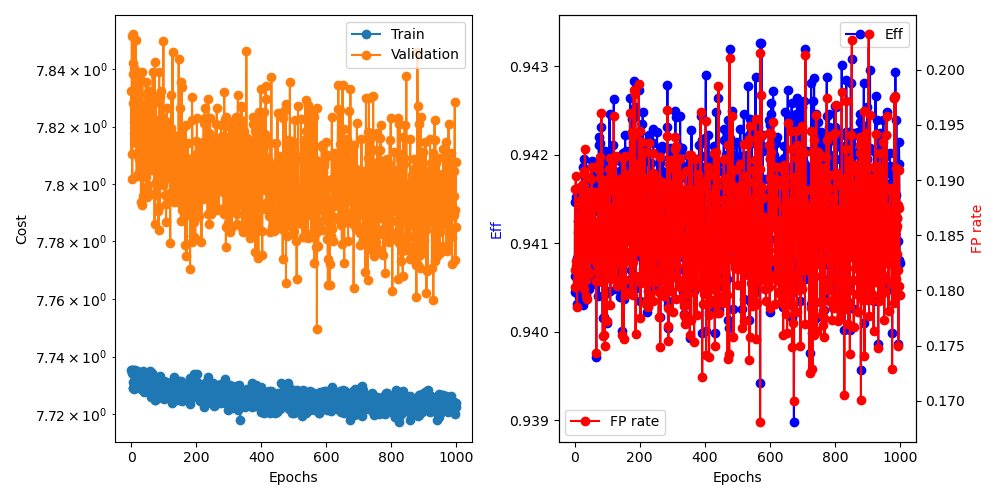

In [12]:
print('for model: ', model)   
run_name = 'ACNN A Continued P3'
# Create an mlflow run
with mlflow.start_run(run_name=run_name) as run:
    # Log parameters of the model
    for key, value in vars(args).items():
        print(key, value)
        mlflow.log_param(key, value)
    
    # Log parameter count in the model
    mlflow.log_param('Parameters', count_parameters(model))
    
    # Begin run
    for result in trainNet(model, optimizer, loss,
                            train_loader, val_loader,
                            args.epochs+args.epoch_start, epoch_start=args.epoch_start,
                            notebook=True, device=device):

        result = result._asdict()
        results = results.append(pd.Series(result), ignore_index=True)
    
        xs = results.index
    
        # Update the plot above
        lines['train'].set_data(results.index,results.cost)
        lines['val'].set_data(results.index,results.val)
    
        #filter first cost epoch (can be really large)
        max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
        min_cost = min(min(results.cost), min(results.val))
    
        # The plot limits need updating too
        ax.set_ylim(min_cost*.9, max_cost*1.1)  
        ax.set_xlim(-.5, len(results.cost) - .5)
    
        replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
        replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
        # Redraw the figure
        fig.canvas.draw()
            
        ## MLFLOW ##
        # Log metrics
        mlflow.log_metric('Efficiency', result['eff_val'].eff_rate, result['epoch'])
        mlflow.log_metric('False Positive Rate',  result['eff_val'].fp_rate, result['epoch'])
        mlflow.log_metric('Validation Loss',  result['val'], result['epoch'])
        mlflow.log_metric('Training Loss',  result['cost'], result['epoch'])
            
        # Log tags
#        mlflow.set_tag('Optimizer', 'Adam')
#        mlflow.set_tag('Kernel size', 'Mixed')
#        mlflow.set_tag('Skip connections', '4')
#        mlflow.set_tag('Activation', 'Softplus')
#        mlflow.set_tag('Mid Activation', 'Relu')
        mlflow.set_tag('Extra Data', 'False')

        # Save model state dictionary, optimizer state dictionary, and epoch number
        torch.save({
            'model':model.state_dict(),
            'optimizer':optimizer.state_dict(),
            'epoch':args.epochs+result['epoch']
            }, 'run_stats.pyt')
        # Save the run stats into mlflow
        mlflow.log_artifact('run_stats.pyt')
            
        # Save a diagram of the architecture
#        HL.transforms.Fold("Conv", "Conv"),
#        HL.build_graph(model, torch.zeros([args.batch_size, 1, 4000]).to(device)).save('architecture', format='png')
#        mlflow.log_artifact('architecture.png')
        
        # log the code for the model architecture
#        mlflow.log_artifact('architecture.txt')
        
    dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
    # save plot
    plt.tight_layout()
    plt.savefig('plot.png')
    mlflow.log_artifact('plot.png')

In [13]:
##quit()